In [1]:
import skimage
import tifffile
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path
import os
from scipy.optimize import curve_fit
from matplotlib import rcParams
from statsmodels.stats.weightstats import ttest_ind
from statannotations.Annotator import Annotator
rcParams['figure.dpi'] = 250
plt.rcParams['figure.figsize'] = (20, 10)
plt.rcParams['font.size'] = 20

In [2]:
class Plate():

    def __init__(self, data_dir, analysis_name):
        self.data_dir = data_dir
        self.analysis_name = analysis_name
        self._load_data()
        self._load_platemap()

    def _load_data(self):
            
        self.image_data = pd.read_csv(self.data_dir / 
                                self.analysis_name /
                                (self.analysis_name + 'Image.csv'))
        self.soma_data = pd.read_csv(self.data_dir / 
                                self.analysis_name /
                                (self.analysis_name + 'cytoplasm_outlines.csv'))
        self.nuclei_data = pd.read_csv(self.data_dir / 
                                self.analysis_name /
                                (self.analysis_name + 'nuclei.csv'))
    
    def _load_platemap(self):
        self.platemap = pd.read_csv(self.data_dir / 'platemap.csv') 
        

In [3]:
def calculate_ratio(plate, measurement):

    ratio_data = pd.DataFrame(index = plate.soma_data.index)

    # Set filename and well position
    ratio_data['FileName_TDP43'] = plate.soma_data['FileName_TDP43']
    ratio_data['well_position'] = ratio_data['FileName_TDP43'].apply(
        lambda fname : chr(int(fname[1:3])+64) + fname[4:6]
    )
    ratio_data['row'] = ratio_data['FileName_TDP43'].apply(
    lambda fname : int(fname[1:3])
    )
    ratio_data['col'] = ratio_data['FileName_TDP43'].apply(
        lambda fname : int(fname[4:6])
    )

    # Get mean TDP43 in nucleus
    ratio_data['TDP43_nucleus'] = (
        plate.nuclei_data[measurement] / 
        plate.nuclei_data['AreaShape_Area']
        )

    # Get mean TDP43 in cytoplasm, subtracting out nucleus first
    ratio_data['TDP43_cytoplasm'] = (
        (plate.soma_data[measurement] - 
        plate.nuclei_data[measurement]) /  
        (plate.soma_data['AreaShape_Area'] - 
        plate.nuclei_data['AreaShape_Area'])
    )

    # Get ratio of cytoplasm / nucleus
    ratio_data['TDP43_ratio'] = (
        ratio_data['TDP43_cytoplasm'] / 
        ratio_data['TDP43_nucleus']
    )
    return ratio_data


In [5]:
def sigmoid(x, a, b, c):
     y = 1 / (1 + np.exp(-b*(x-a)))
     return y + c

# Calcualte CRCs for MG132 and BTZ

## Single plate analysis

In [1]:
# data_dir = Path('/lab/processed-data/ALS0002_NGN2_DIV11_MG132DRCv3/DIV11 v3 lower AF488__2023-02-15T08_40_16-Measurement 1')
data_dir = Path('/lab/processed-data/ALS0002_NGN2_DIV18_MG132DRCv3/DIV18v2__2023-02-21T14_27_22-Measurement 1')
analysis_name = '2023-02-17_tdp43seg_tdp-43'
measurement = 'Intensity_IntegratedIntensity_TDP43_corrected'

plate = Plate(data_dir, analysis_name)
ratio_data = calculate_ratio(plate, measurement)
ratio_data = ratio_data.merge(plate.platemap, on='well_position')
ratio_data = ratio_data.groupby(['well_position', 'treatment', 'concentration']).mean()
ratio_data = ratio_data.reset_index()
     
sns.set_style('darkgrid')
pal = sns.color_palette('colorblind')

# Plot data
sns.scatterplot(data=ratio_data, x='concentration', y='TDP43_ratio', hue='treatment', s=150, alpha=0.6, palette=pal)

# Fit sigmoid curves for MG132 and BTZ conditions & plot
concentrations = ratio_data['concentration'].unique()
x_range = np.arange(concentrations.min(), concentrations.max(), 0.01)

data = ratio_data.query('treatment=="MG132"')
params = curve_fit(
    sigmoid, 
    xdata=data['concentration'], 
    ydata=data['TDP43_ratio']
)[0]
y_fit = sigmoid(x_range, params[0],  params[1],  params[2])
plt.plot(x_range, y_fit, color=pal[1])

data = ratio_data.query('treatment=="BTZ"')
params = curve_fit(
    sigmoid, 
    xdata=data['concentration'], 
    ydata=data['TDP43_ratio']
)[0]
y_fit = sigmoid(x_range, params[0],  params[1],  params[2])
plt.plot(x_range, y_fit, color=pal[2])

plt.xticks(rotation = 30)
# plt.ylim([0.8, 1.4])
# plt.xscale('log')
# plt.title('ALS0002_NGN2_DIV11_MG132DRCv3 - DIV11 v3 lower AF488__2023-02-15T08_40_16-Measurement 1')
plt.title('ALS0002_NGN2_DIV18_MG132DRCv3 - DIV18v2__2023-02-21T14_27_22-Measurement 1')
plt.legend(loc='lower right')
dmso_controls = ratio_data.query('treatment=="DMSO"')
# xlims = [data['concentration'].min(), data['concentration'].max()]
xlims = plt.gca().get_xlim()
plt.plot(
     xlims,
     [dmso_controls['TDP43_ratio'].mean(), 
      dmso_controls['TDP43_ratio'].mean()],
     color = pal[0])
plt.xlim(xlims)

NameError: name 'sns' is not defined

## Multi-plate analysis

In [14]:
ratio_data

index                  FileName_TDP43 well_position  row  col  \
671      671  r02c03f02p01-ch2sk1fk1fl1.tiff           B03    2    3   
672      672  r02c03f02p01-ch2sk1fk1fl1.tiff           B03    2    3   
673      673  r02c03f02p01-ch2sk1fk1fl1.tiff           B03    2    3   
674      674  r02c03f02p01-ch2sk1fk1fl1.tiff           B03    2    3   
675      675  r02c03f02p01-ch2sk1fk1fl1.tiff           B03    2    3   
...      ...                             ...           ...  ...  ...   
78899  78899  r07c10f24p01-ch2sk1fk1fl1.tiff           G10    7   10   
78900  78900  r07c10f24p01-ch2sk1fk1fl1.tiff           G10    7   10   
78901  78901  r07c10f24p01-ch2sk1fk1fl1.tiff           G10    7   10   
78902  78902  r07c10f24p01-ch2sk1fk1fl1.tiff           G10    7   10   
78903  78903  r07c10f24p01-ch2sk1fk1fl1.tiff           G10    7   10   

       TDP43_nucleus  TDP43_cytoplasm  TDP43_ratio treatment  concentration  \
671         0.171654         0.223889     1.304302     MG132           2.00   
672         0.251937         0.258294     1.025231     MG132           2.00   
673         0.187328         0.212075     1.132102     MG132           2.00   
674         0.177705         0.240354     1.352547     MG132           2.00   
675         0.139283         0.173065     1.242539     MG132           2.00   
...              ...              ...          ...       ...            ...   
78899       0.152258         0.193233     1.269116     MG132           0.25   
78900       0.122632         0.136950     1.116763     MG132           0.25   
78901       0.559679         0.422763     0.755366     MG132           0.25   
78902       0.211602         0.155777     0.736177     MG132           0.25   
78903       0.100402         0.150731     1.501276     MG132           0.25   

       crispr  
671       NaN  
672       NaN  
673       NaN  
674       NaN  
675       NaN  
...       ...  
78899  RESP18  
78900  RESP18  
78901  RESP18  
78902  RESP18  
78903  RESP18  

[210380 rows x 11 columns]

In [8]:
analysis_name = '2023-02-17_tdp43seg_tdp-43'
measurement = 'Intensity_IntegratedIntensity_TDP43_corrected'
data_dir = Path('/lab/processed-data')
experiments = [
    'ALS0002_NGN2_DIV11_MG132DRCv3/DIV11 v3 lower AF488__2023-02-15T08_40_16-Measurement 1',
    'ALS0002_NGN2_DIV18_MG132DRCv3/DIV18v2__2023-02-21T14_27_22-Measurement 1',
    'ALS0006_NGN2_DIV11_KOv1_MG132/DIV11__2023-02-15T11_31_26-Measurement 1',
    'ALS0006_NGN2_DIV18_KOv1_MG132/DIV18__2023-02-24T08_47_12-Measurement 1'
               ]

ratio_data = pd.DataFrame()

for exp in experiments[0]:
    plate = Plate(data_dir / exp, analysis_name)
    rd = calculate_ratio(plate, measurement)
    rd = rd.merge(plate.platemap, on='well_position')

    # Remove images with fewer than 10 or more than 400 cells
    cell_counts = rd.groupby('FileName_TDP43').size()
    rd.index = rd['FileName_TDP43'].values
    rd = rd.drop(index=cell_counts[cell_counts < 10].index)
    rd = rd.drop(index=cell_counts[cell_counts > 400].index)
    
    rd = rd.groupby(
        # ['well_position', 'treatment', 'concentration']
        ['FileName_TDP43', 'treatment', 'concentration', 'well_position']
    ).mean(numeric_only=True)
    rd = rd.reset_index()
    # rd['exp'] = exp

    # Remove 'empty' from concentration. TODO: use QC column instead
    rd = rd.drop(
        rd.index[rd['concentration'] == 'empty']
    )
    # Force concentration to be float
    rd['concentration'] = rd['concentration'].astype(float)
    # rd['TDP43_ratio'] -= rd.query('treatment == "DMSO" & concentration == 0')['TDP43_ratio'].mean()
    ratio_data = pd.concat([ratio_data, rd])
    
# Remove B02, should be dealt with in QC column
ratio_data = ratio_data.drop(
    ratio_data.index[ratio_data['well_position'] == 'B02']
)
# Remove NaNs
ratio_data = ratio_data.drop(
    ratio_data.index[ratio_data['TDP43_ratio'].isna()]
)

FileNotFoundError: [Errno 2] No such file or directory: '/lab/processed-data/A/2023-02-17_tdp43seg_tdp-43/2023-02-17_tdp43seg_tdp-43Image.csv'

/tmp/ipykernel_20217/48237023.py:10: UserWarning: The palette list has more values (10) than needed (3), which may not be intended.
  sns.scatterplot(data=jitter_data, x='concentration', y='TDP43_ratio', hue='treatment',hue_order=['DMSO', 'MG132', 'BTZ'], s=150, alpha=0.3, palette=pal)


Text(0.5, 1.0, 'CRC pooled across experiments')

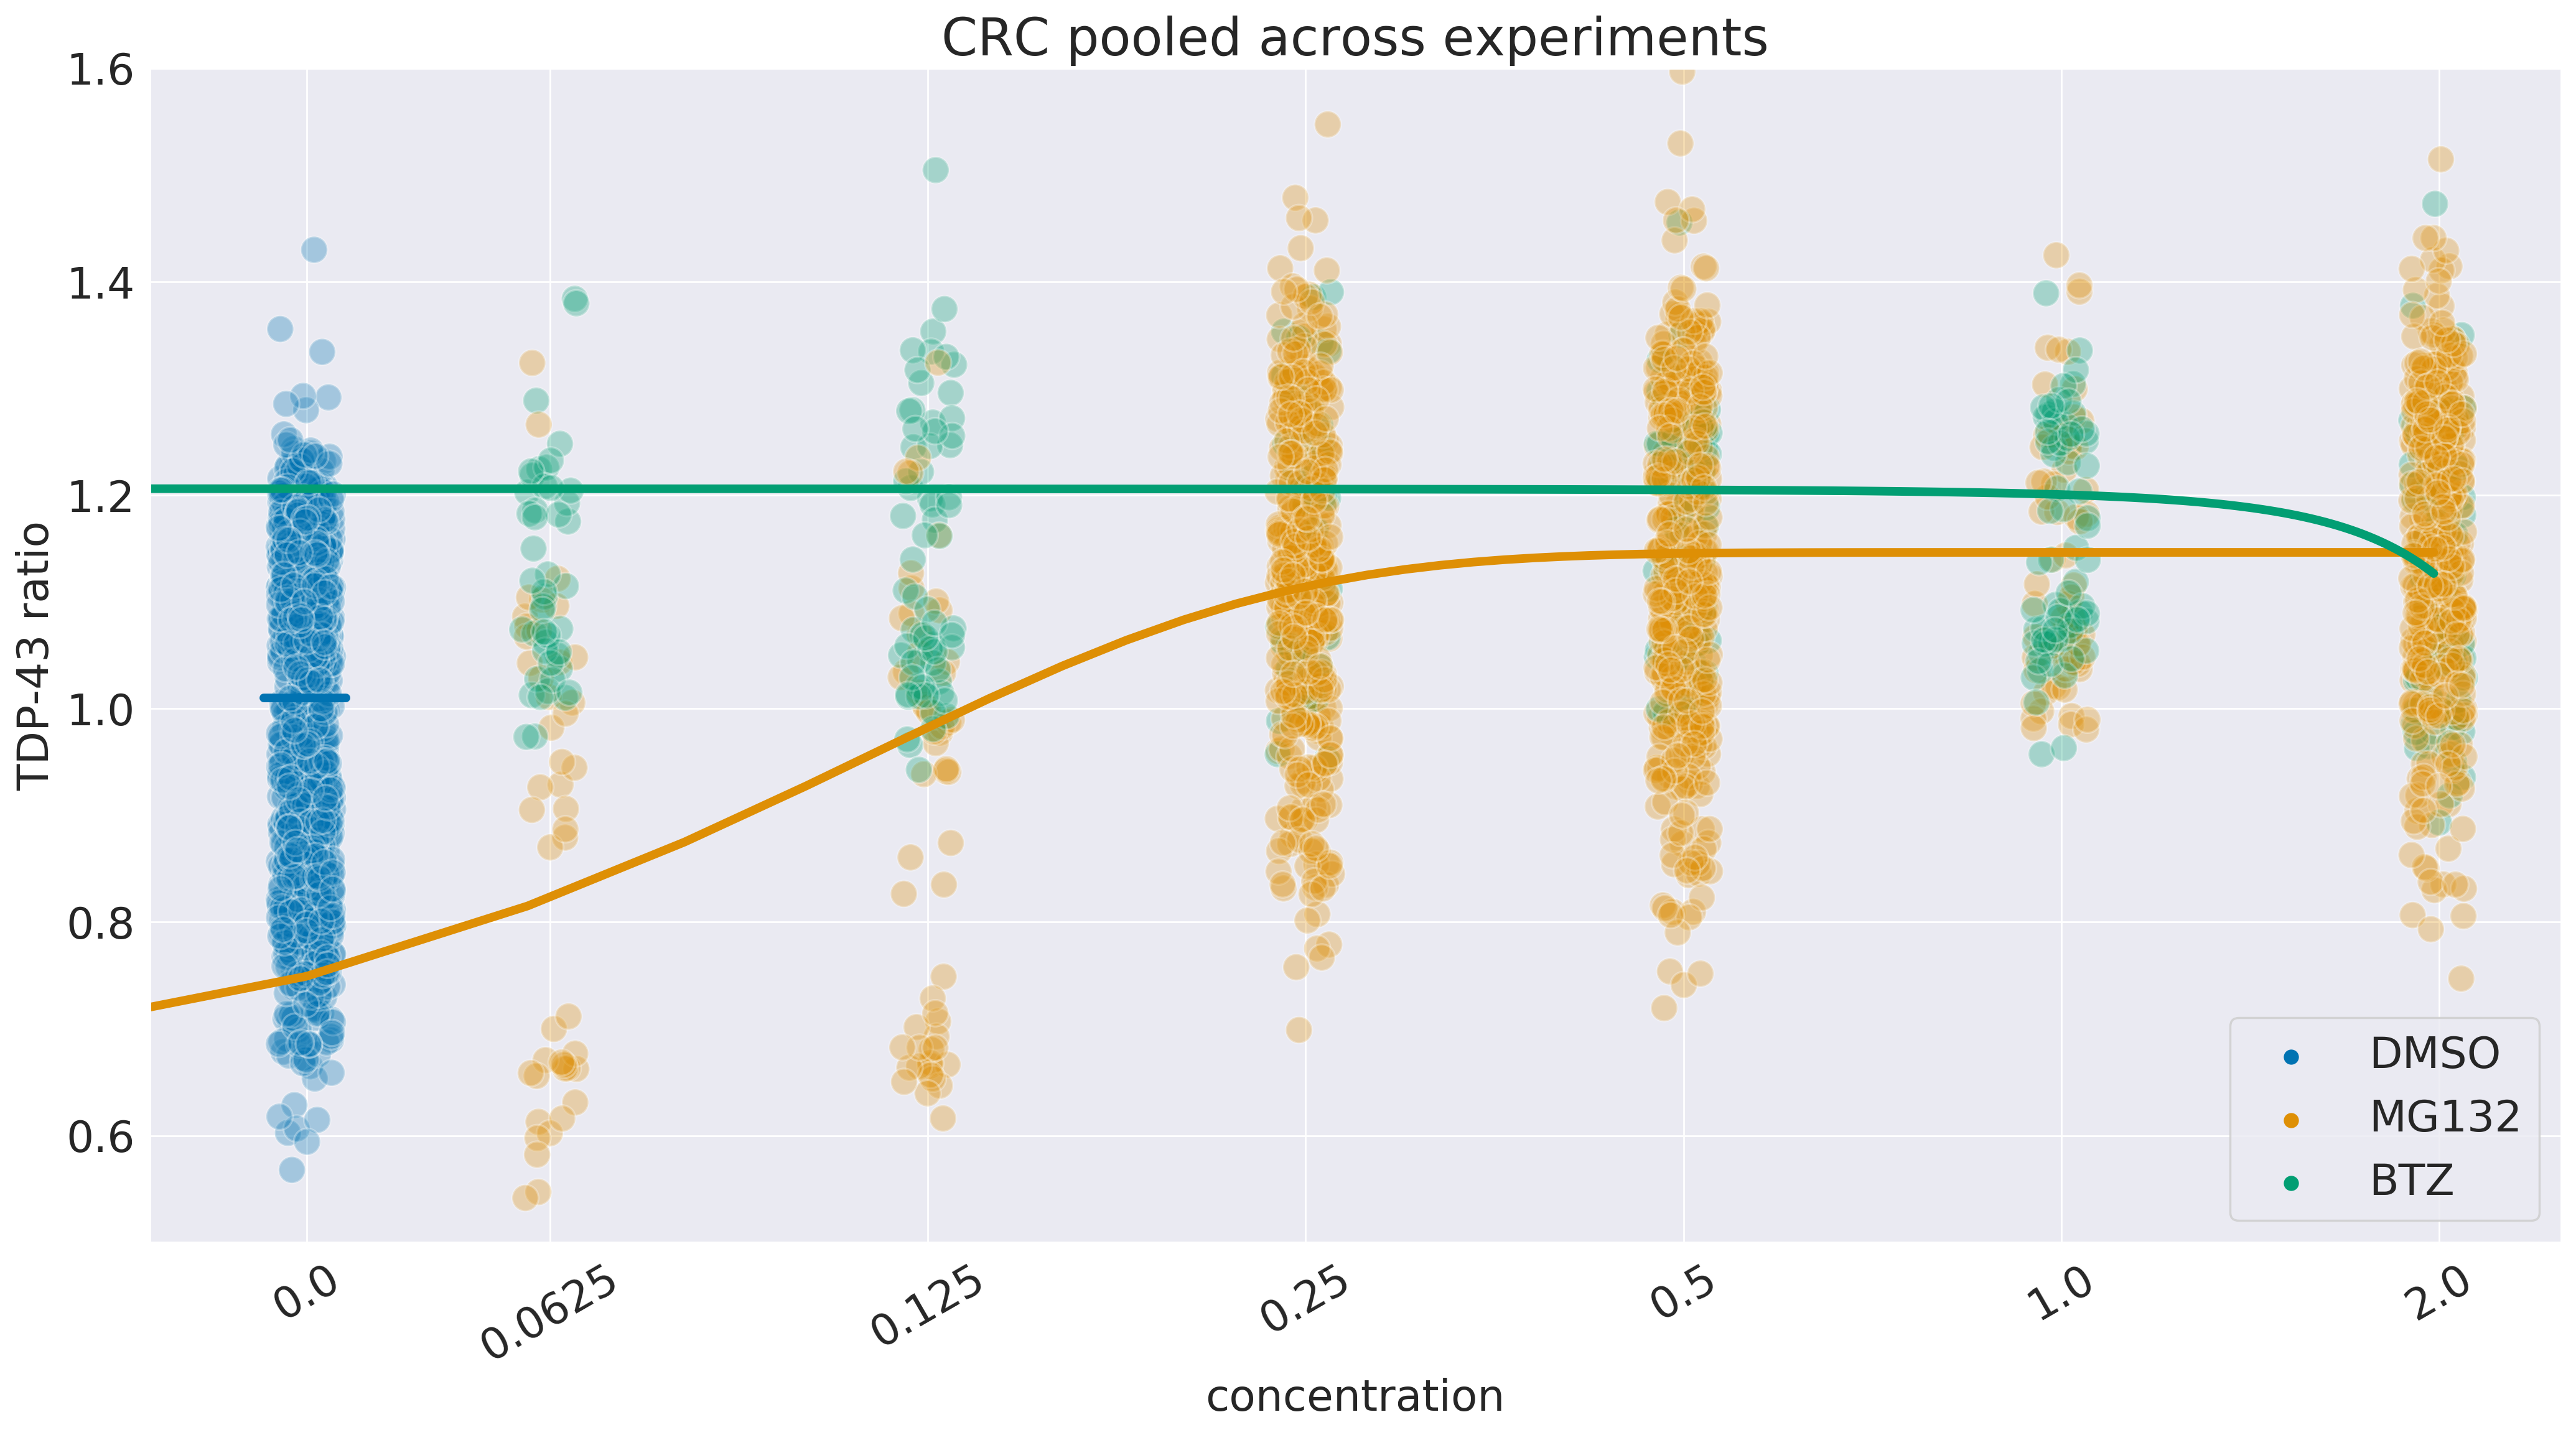

In [133]:
import matplotlib.ticker as ticker
sns.set_style('darkgrid')
pal = sns.color_palette('colorblind')

# Plot data
jitter_data = ratio_data.copy()
jitter_data.loc[jitter_data['concentration'] == 0, 'concentration'] = 0.04
xticks = np.sort(jitter_data['concentration'].unique())
jitter_data['concentration'] += (np.random.random(jitter_data.shape[0])-0.5)*0.1*jitter_data['concentration']
sns.scatterplot(data=jitter_data, x='concentration', y='TDP43_ratio', hue='treatment',hue_order=['DMSO', 'MG132', 'BTZ'], s=150, alpha=0.3, palette=pal)
# sns.stripplot(data=jitter_data, x='concentration', y='TDP43_ratio', hue='treatment', dodge=True, hue_order=['DMSO', 'MG132', 'BTZ'], s=10, alpha=0.6, palette=pal)
# sns.violinplot(data=ratio_data, x='concentration', y='TDP43_ratio', hue='treatment', hue_order=['DMSO', 'MG132', 'BTZ'], palette=pal)
# ax = plt.gca()
# ax.xaxis.set_major_locator(ticker.FixedLocator(locs=np.sort(ratio_data['concentration'].unique())))
# ax.xaxis.set_major_formatter(ticker.ScalarFormatter())

# Fit sigmoid curves for MG132 and BTZ conditions & plot
concentrations = ratio_data['concentration'].unique()
x_range = np.arange(concentrations.min(), concentrations.max(), 0.02)

data = ratio_data.query('treatment=="MG132"')
params = curve_fit(
    sigmoid, 
    xdata=data['concentration'], 
    ydata=data['TDP43_ratio']
)[0]
y_fit = sigmoid(x_range, params[0],  params[1],  params[2])
plt.plot(x_range, y_fit, color=pal[1], linewidth=4)

data = ratio_data.query('treatment=="BTZ"')
params = curve_fit(
    sigmoid, 
    xdata=data['concentration'], 
    ydata=data['TDP43_ratio']
)[0]
y_fit = sigmoid(x_range, params[0],  params[1],  params[2])
plt.plot(x_range, y_fit, color=pal[2], linewidth=4)

plt.xticks(rotation = 30)
# plt.ylim([0.8, 1.4])
plt.xscale('log')
# plt.title('ALS0002_NGN2_DIV11_MG132DRCv3 - DIV11 v3 lower AF488__2023-02-15T08_40_16-Measurement 1')
# plt.title('ALS0002_NGN2_DIV18_MG132DRCv3 - DIV18v2__2023-02-21T14_27_22-Measurement 1')
plt.legend(loc='lower right')
dmso_controls = ratio_data.query('treatment=="DMSO"')
# xlims = [data['concentration'].min(), data['concentration'].max()]
# xlims = plt.gca().get_xlim()
plt.plot(
     [0.037, 0.043],
     [dmso_controls['TDP43_ratio'].mean(), 
      dmso_controls['TDP43_ratio'].mean()],
     color = pal[0],
     linewidth=4)
plt.xlim([0.03, 2.5])
plt.ylim([0.5, 1.6])
# plt.ylim([-0.55, 0.55])
# plt.ylabel('Δ TDP-43 ratio')
plt.ylabel('TDP-43 ratio')
ax = plt.gca()
ax.set_xticks(xticks)
xticks = np.sort(ratio_data['concentration'].unique())
ax.set_xticklabels(xticks)
plt.title('CRC pooled across experiments')

In [141]:
poscon = ratio_data.query('treatment=="DMSO"')['TDP43_ratio']
negcon = ratio_data.query('treatment=="MG132" & concentration==2')['TDP43_ratio']

In [143]:
1 - ((3 * (poscon.std() + negcon.std())) / np.abs(poscon.mean() - negcon.mean()))

-13.97200451125008

p-value annotation legend:
      ns: p <= 1.00e+00
       *: 1.00e-02 < p <= 5.00e-02
      **: 1.00e-03 < p <= 1.00e-02
     ***: 1.00e-04 < p <= 1.00e-03
    ****: p <= 1.00e-04

MG132 vs. DMSO: t-test independent samples, P_val:1.456e-05 t=4.643e+00


/tmp/ipykernel_20217/1590822236.py:6: FutureWarning: Passing `palette` without assigning `hue` is deprecated.
  sns.stripplot(data=d, x='treatment', y='TDP43_ratio', order=hue_order, linewidth=2, size=10, palette='colorblind', alpha=0.7)


(0.5, 1.65)

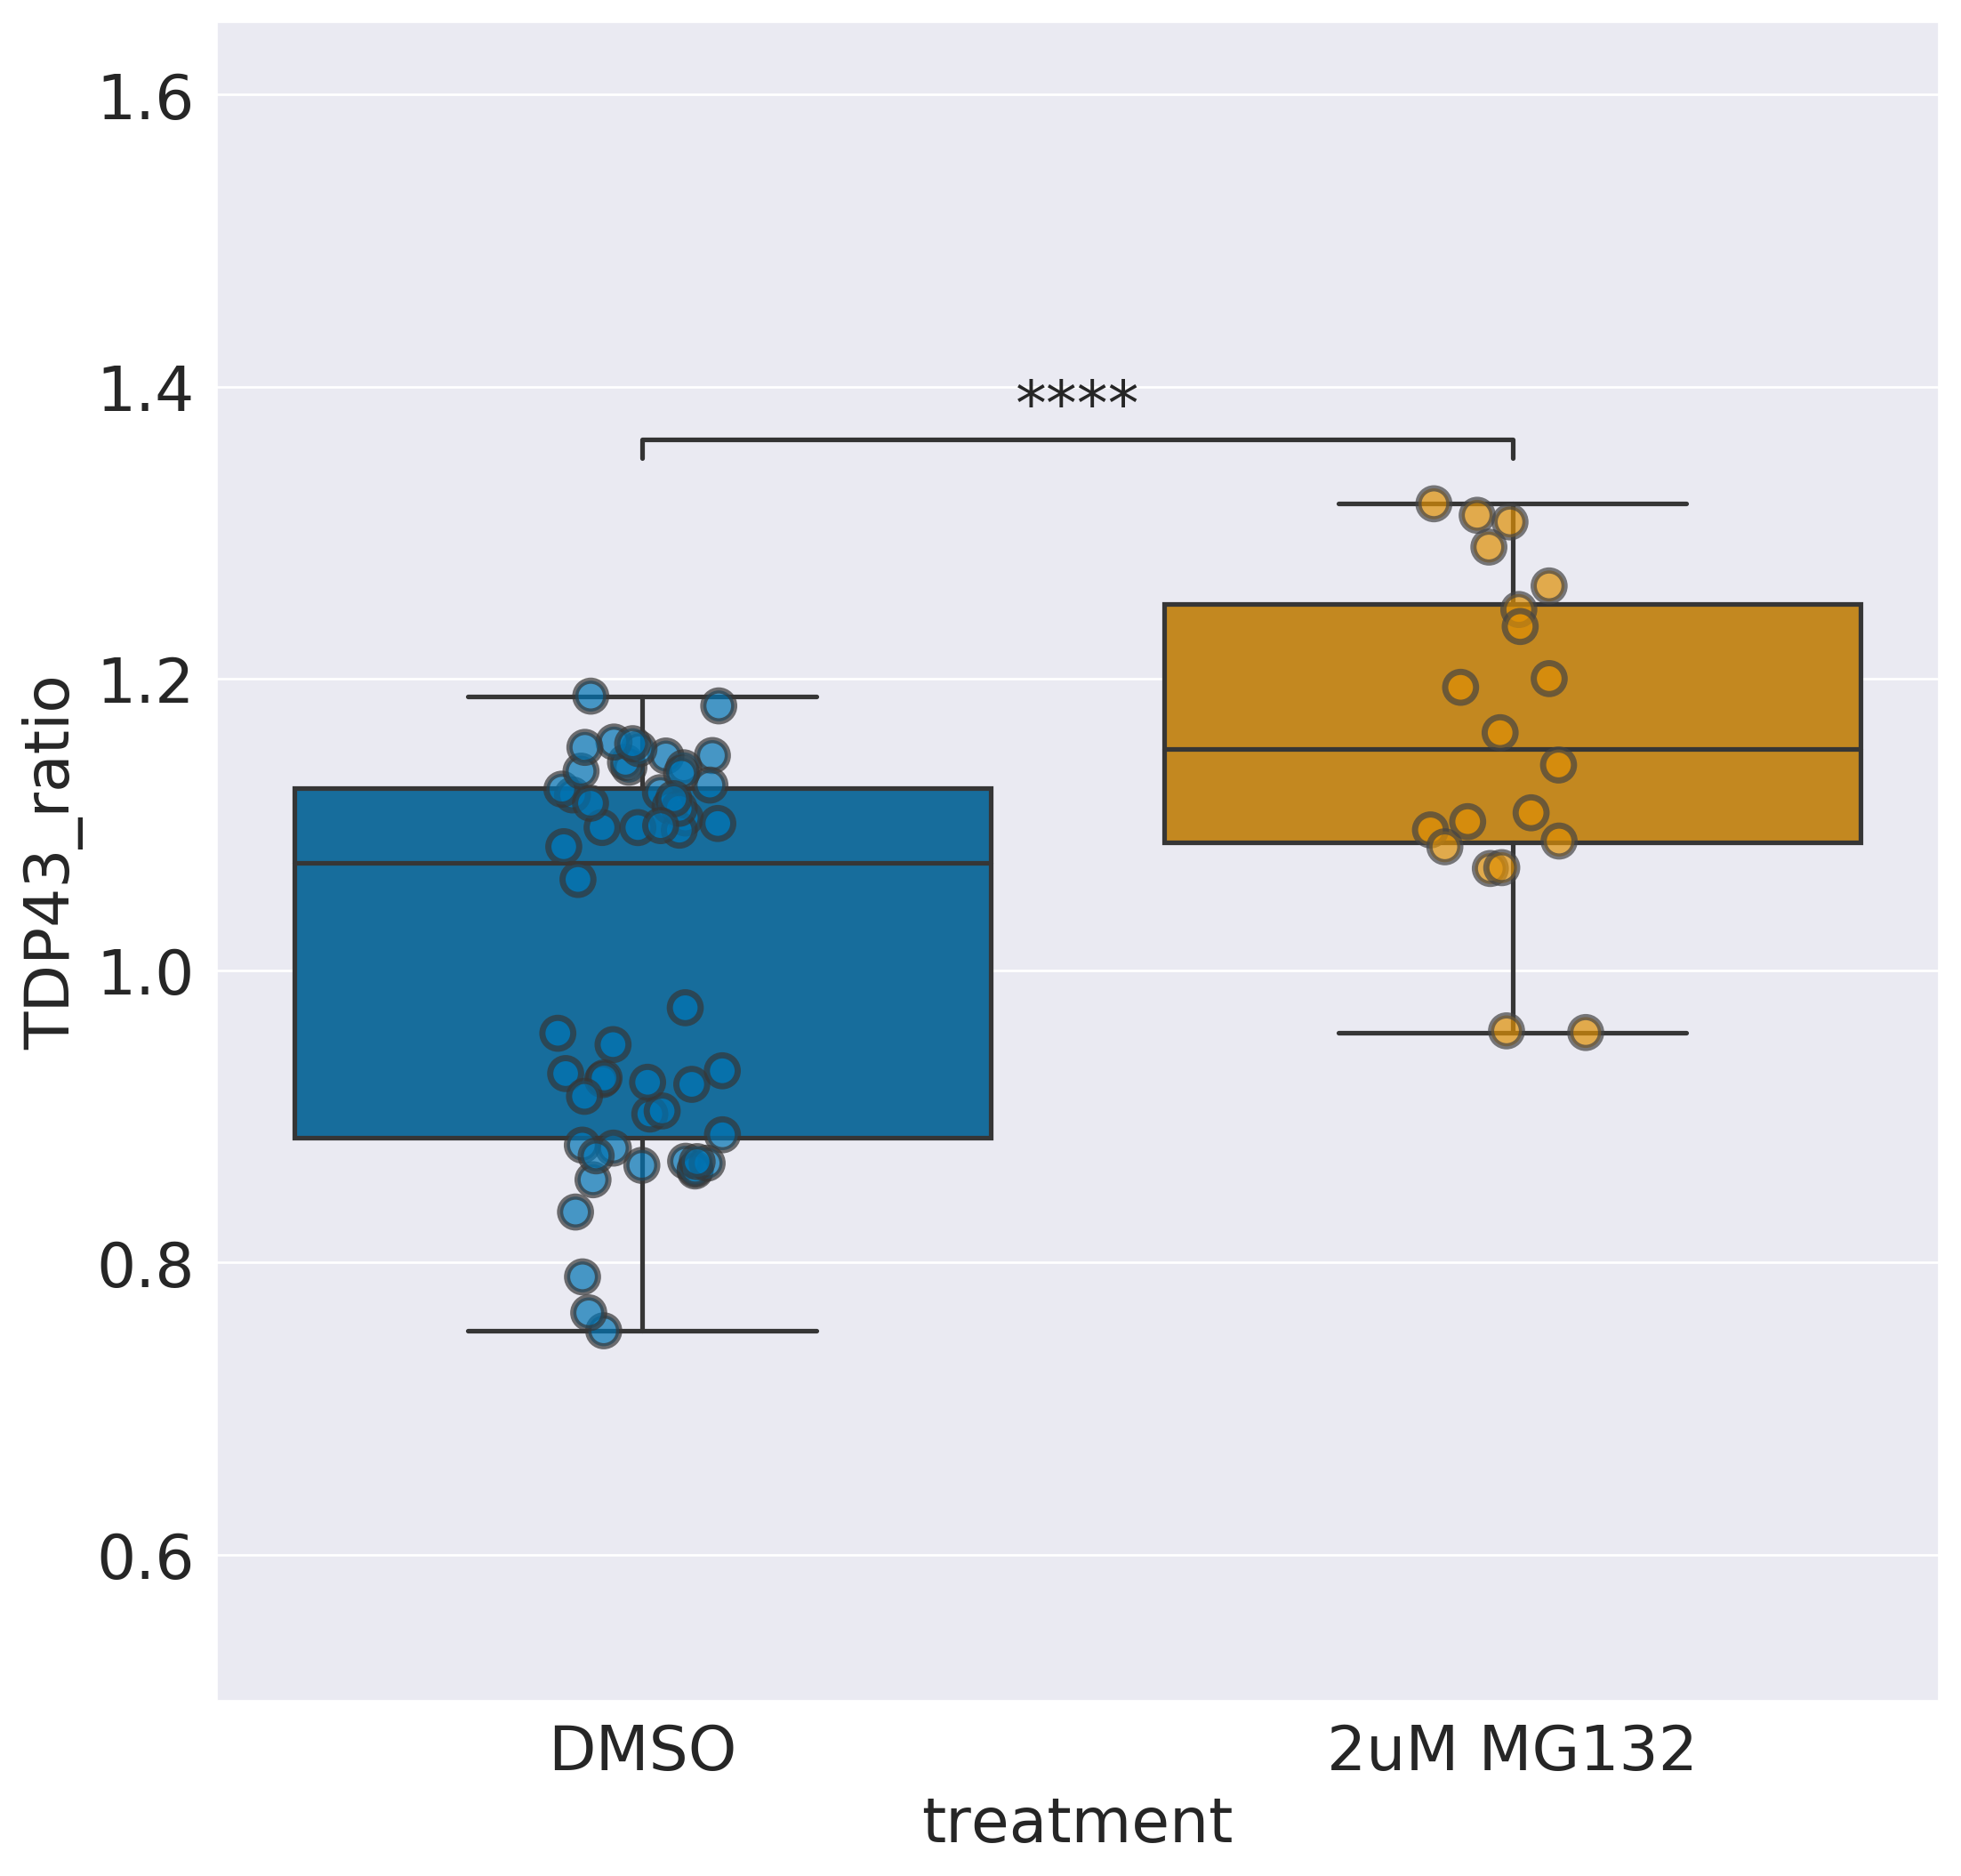

In [179]:
plt.rcParams['figure.figsize'] = (10, 10)
d = ratio_data.query('treatment=="DMSO" or (treatment=="MG132" & concentration==2)')
d = d.drop(d.index[d['TDP43_ratio'] > 2])
hue_order=['DMSO', 'MG132']
ax = sns.boxplot(data=d, x='treatment', y='TDP43_ratio', order=hue_order, palette='colorblind')
sns.stripplot(data=d, x='treatment', y='TDP43_ratio', order=hue_order, linewidth=2, size=10, palette='colorblind', alpha=0.7)

pairs = [['DMSO', 'MG132']]
annot = Annotator(ax, pairs, data=d, x='treatment', y='TDP43_ratio')
annot.configure(test='t-test_ind', text_format='star',  verbose=2)
annot.apply_test().annotate(line_offset_to_group=0.05)
ax.set_xticklabels(['DMSO', '2uM MG132'])
plt.ylim([0.5, 1.65])

In [32]:
analysis_name = '2023-02-17_tdp43seg_tdp-43'
measurement = 'Intensity_IntegratedIntensity_TDP43_corrected'
data_dir = Path('/lab/processed-data')
experiments = [
    'ALS0002_NGN2_DIV11_MG132DRCv3/DIV11 v3 lower AF488__2023-02-15T08_40_16-Measurement 1',
    'ALS0002_NGN2_DIV18_MG132DRCv3/DIV18v2__2023-02-21T14_27_22-Measurement 1',
    'ALS0006_NGN2_DIV11_KOv1_MG132/DIV11__2023-02-15T11_31_26-Measurement 1',
    'ALS0006_NGN2_DIV18_KOv1_MG132/DIV18__2023-02-24T08_47_12-Measurement 1'
               ]

ratio_data = pd.DataFrame()

exp = experiments[3]
plate = Plate(data_dir / exp, analysis_name)
rd = calculate_ratio(plate, measurement)
rd = rd.merge(plate.platemap, on='well_position')

# Remove images with fewer than 10 or more than 400 cells
cell_counts = rd.groupby('FileName_TDP43').size()
rd.index = rd['FileName_TDP43'].values
rd = rd.drop(index=cell_counts[cell_counts < 10].index)
rd = rd.drop(index=cell_counts[cell_counts > 400].index)

rd = rd.groupby(
    # ['well_position', 'treatment', 'concentration']
    ['FileName_TDP43', 'treatment', 'concentration', 'well_position']
).mean(numeric_only=True)
rd = rd.reset_index()
# rd['exp'] = exp

# Remove 'empty' from concentration. TODO: use QC column instead
rd = rd.drop(
    rd.index[rd['concentration'] == 'empty']
)
# Force concentration to be float
rd['concentration'] = rd['concentration'].astype(float)
# rd['TDP43_ratio'] -= rd.query('treatment == "DMSO" & concentration == 0')['TDP43_ratio'].mean()
ratio_data = pd.concat([ratio_data, rd])
    
# Remove B02, should be dealt with in QC column
ratio_data = ratio_data.drop(
    ratio_data.index[ratio_data['well_position'] == 'B02']
)
# Remove NaNs
ratio_data = ratio_data.drop(
    ratio_data.index[ratio_data['TDP43_ratio'].isna()]
)

p-value annotation legend:
      ns: p <= 1.00e+00
       *: 1.00e-02 < p <= 5.00e-02
      **: 1.00e-03 < p <= 1.00e-02
     ***: 1.00e-04 < p <= 1.00e-03
    ****: p <= 1.00e-04

DMSO vs. MG132: t-test independent samples with Bonferroni correction, P_val:1.922e-78 t=-2.134e+01


/tmp/ipykernel_23885/2134250386.py:7: FutureWarning: Passing `palette` without assigning `hue` is deprecated.
  sns.stripplot(data=d, x='treatment', y='TDP43_ratio', order=hue_order, linewidth=2, size=10, palette='colorblind', alpha=0.7)


Text(0.5, 1, 'DIV18 CRISPR')

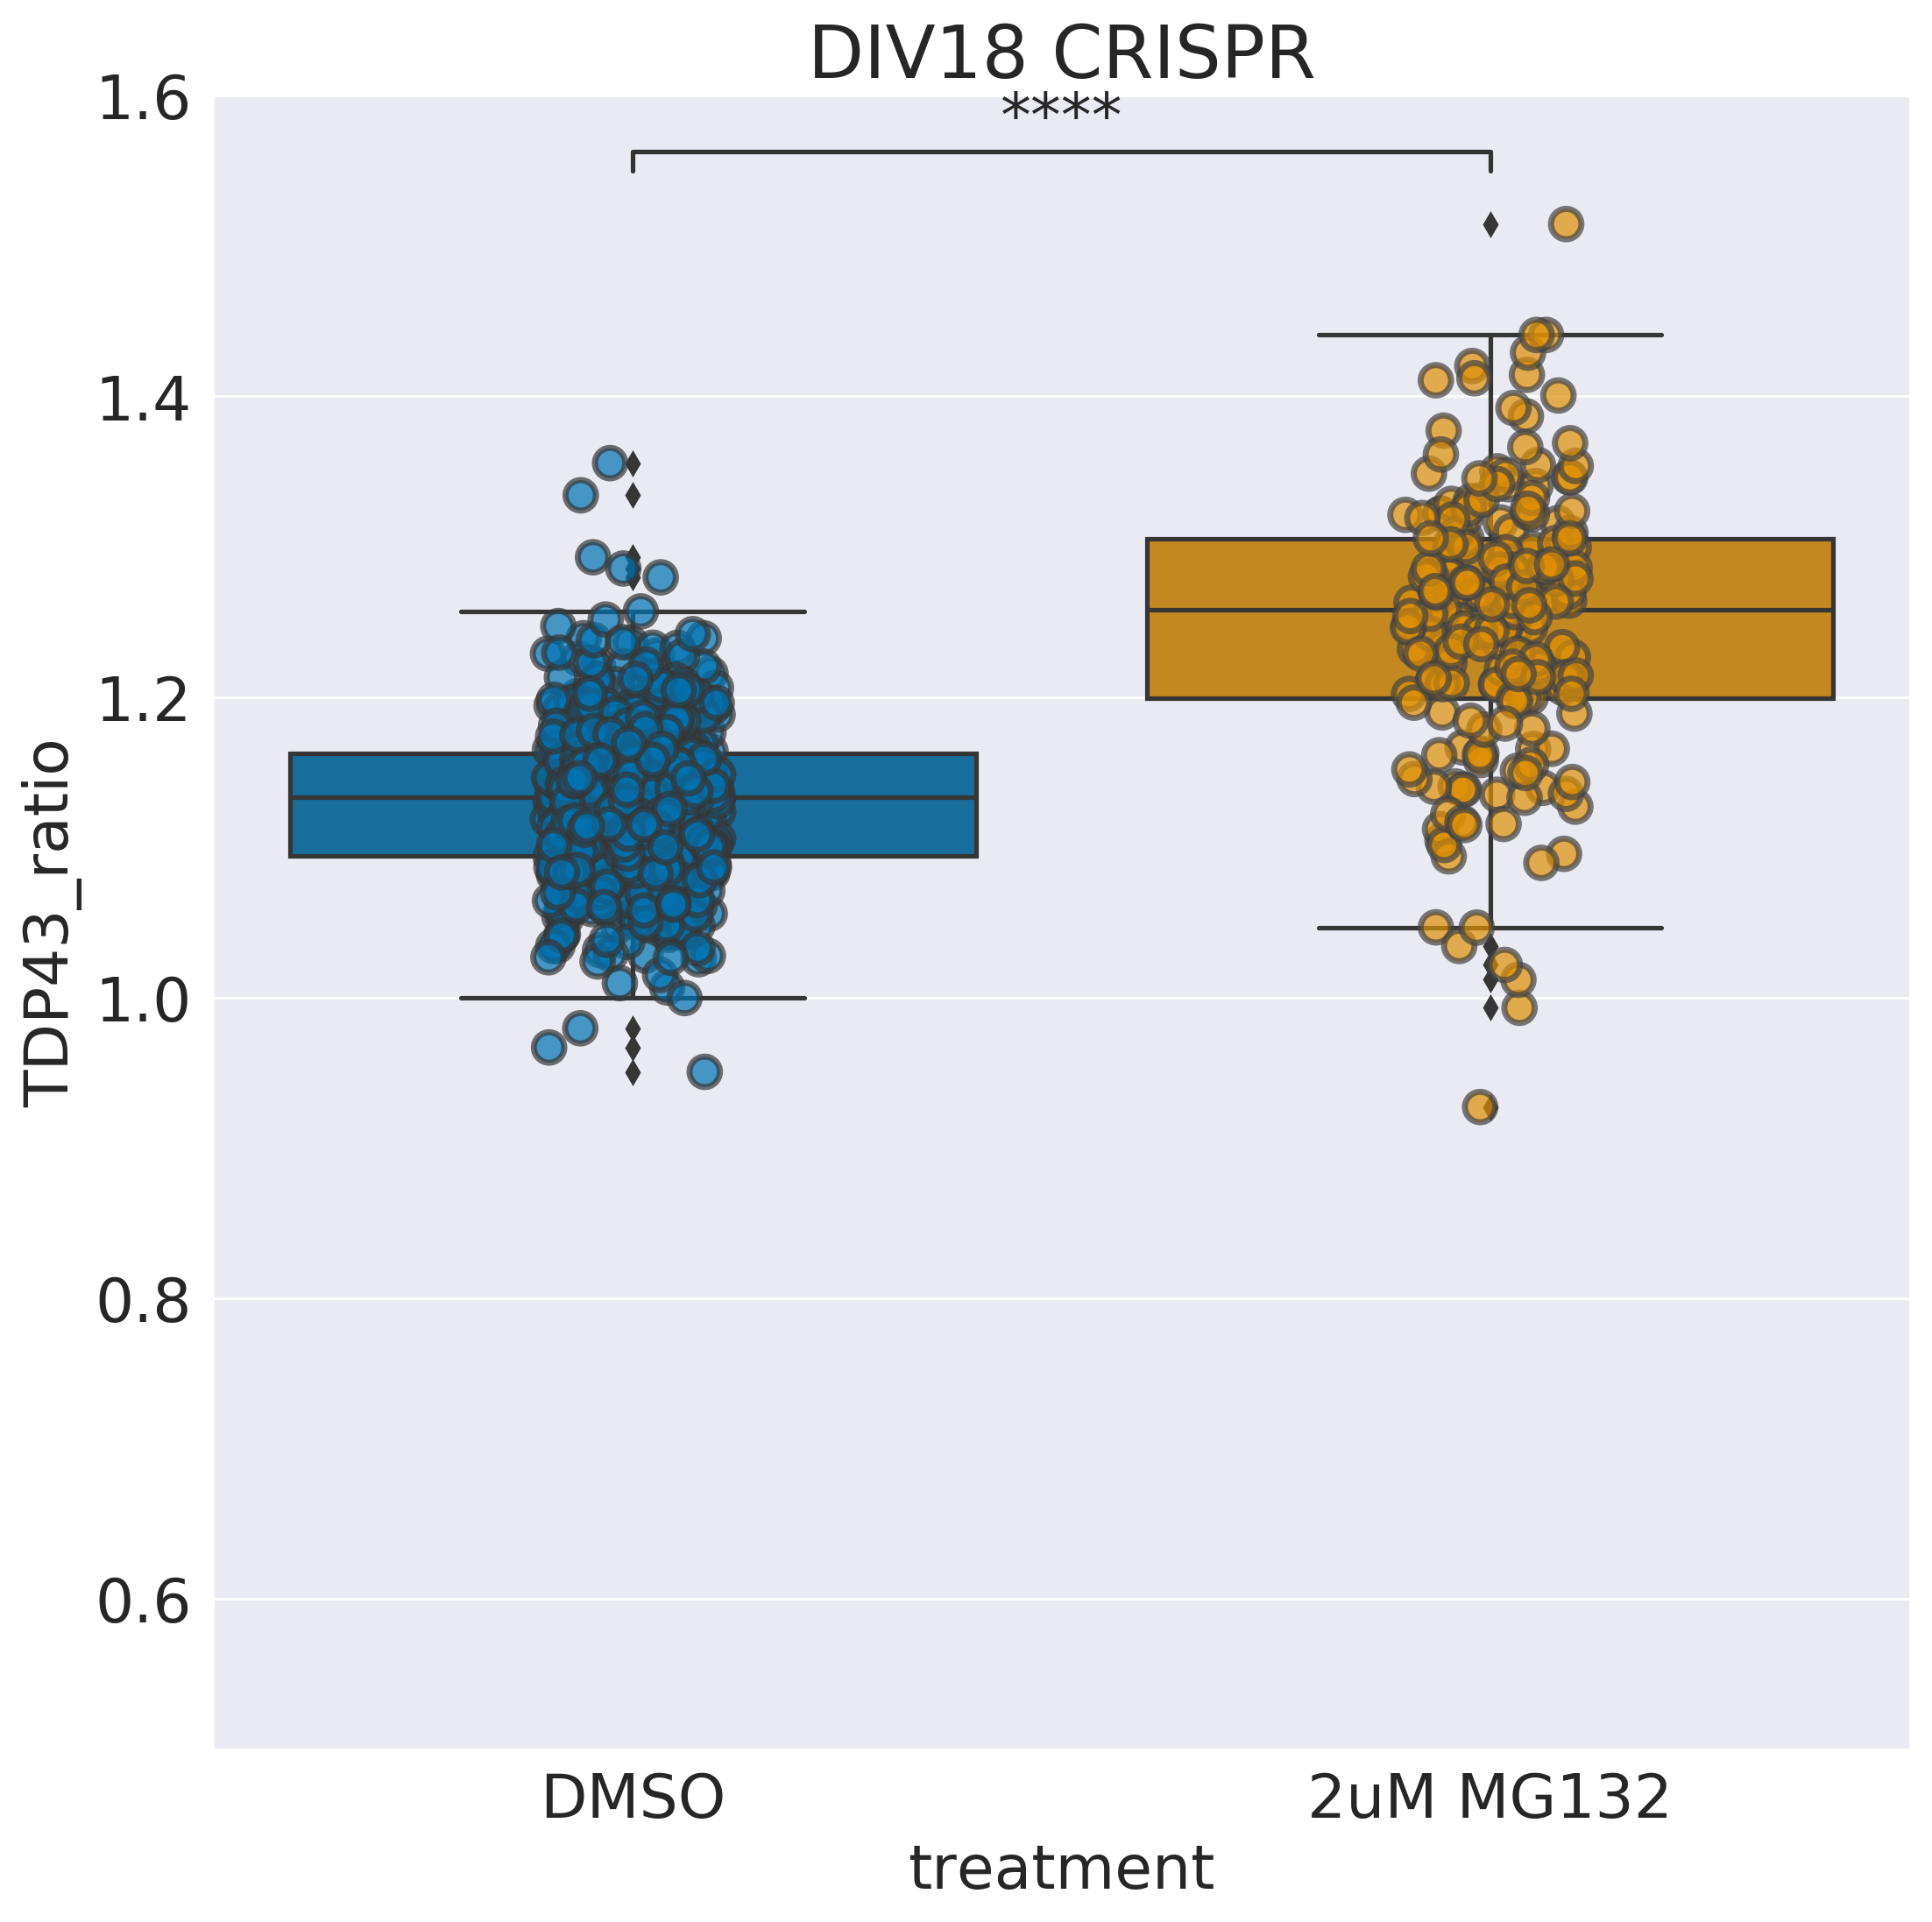

In [33]:
plt.rcParams['figure.figsize'] = (10, 10)
sns.set_style('darkgrid')
d = ratio_data.query('treatment=="DMSO" or (treatment=="MG132" & concentration==2)')
d = d.drop(d.index[d['TDP43_ratio'] > 2])
hue_order=['DMSO', 'MG132']
ax = sns.boxplot(data=d, x='treatment', y='TDP43_ratio', order=hue_order, palette='colorblind')
sns.stripplot(data=d, x='treatment', y='TDP43_ratio', order=hue_order, linewidth=2, size=10, palette='colorblind', alpha=0.7)

pairs = [['DMSO', 'MG132']]
annot = Annotator(ax, pairs, data=d, x='treatment', y='TDP43_ratio')
annot.configure(test='t-test_ind', text_format='star',  verbose=2, comparisons_correction='bonferroni')
annot.apply_test(num_comparisons=4).annotate(line_offset_to_group=0.05)
ax.set_xticklabels(['DMSO', '2uM MG132'])
plt.ylim([0.5, 1.6])
plt.title('DIV18 CRISPR')

In [48]:
np.sort(ratio_data['concentration'].unique())

array([0.    , 0.0625, 0.125 , 0.25  , 0.5   , 1.    , 2.    ])

In [31]:
sns.objects.Jitter(0.5)

Jitter(width=0, x=0, y=0, seed=None)

# Calculate results for CRISPR experiment

In [63]:
data_dir = Path('/lab/processed-data/ALS0006_NGN2_DIV11_KOv1_MG132/DIV11__2023-02-15T11_31_26-Measurement 1')
# data_dir = Path('/lab/processed-data/ALS0006_NGN2_DIV18_KOv1_MG132/DIV18__2023-02-24T08_47_12-Measurement 1')
analysis_name = '2023-02-17_tdp43seg_tdp-43'
measurement = 'Intensity_IntegratedIntensity_TDP43_corrected'

plate = Plate(data_dir, analysis_name)
ratio_data = calculate_ratio(plate, measurement)
ratio_data = ratio_data.merge(plate.platemap, on='well_position')
# ratio_data = ratio_data.groupby(['well_position', 'crispr', 'treatment', 'concentration']).mean()
ratio_data = ratio_data.groupby(['FileName_TDP43', 'crispr', 'treatment', 'concentration']).mean()
ratio_data = ratio_data.reset_index()

/tmp/ipykernel_26402/3034856649.py:10: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  ratio_data = ratio_data.groupby(['FileName_TDP43', 'crispr', 'treatment', 'concentration']).mean()


## Just the DMSO conditions

NT vs. NT: t-test independent samples, P_val:1.000e+00 t=0.000e+00
NT vs. UNC13A: t-test independent samples, P_val:5.107e-01 t=-6.595e-01
NT vs. C9ORF72: t-test independent samples, P_val:9.309e-01 t=8.690e-02
NT vs. SCFD1: t-test independent samples, P_val:4.447e-05 t=4.214e+00
NT vs. RANBP10: t-test independent samples, P_val:1.874e-01 t=-1.325e+00
NT vs. ZDHHC6: t-test independent samples, P_val:1.923e-01 t=-1.310e+00
NT vs. ZNF142: t-test independent samples, P_val:1.088e-02 t=-2.580e+00
NT vs. RESP18: t-test independent samples, P_val:8.959e-02 t=-1.709e+00


/tmp/ipykernel_31187/3808137432.py:19: FutureWarning: Passing `palette` without assigning `hue` is deprecated.
  sns.stripplot(data=data, x=x, y=y, linewidth=2, size=10, palette='colorblind', alpha=0.7)


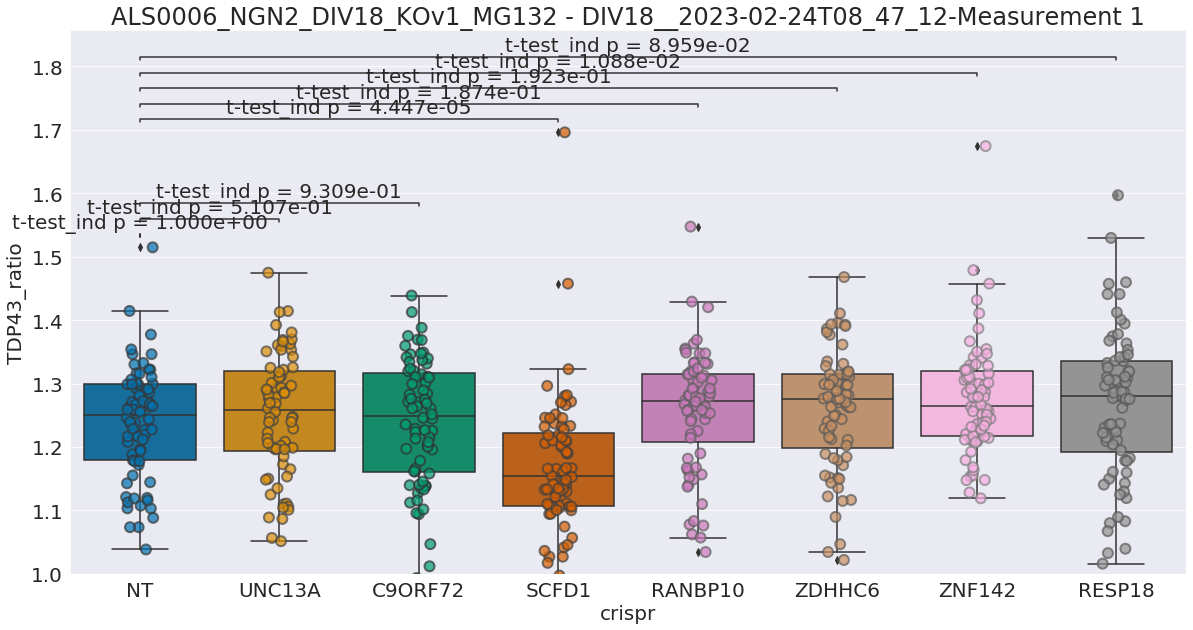

In [61]:
from statannotations.Annotator import Annotator
sns.set_style('darkgrid')
data = ratio_data.query('treatment=="DMSO"')
# data = ratio_data.drop(ratio_data.index[ratio_data['treatment']=='empty'])
x = 'crispr'
y = 'TDP43_ratio'
ax = sns.boxplot(data=data, x=x, y=y, palette='colorblind')
# ax = sns.violinplot(data=data, x=x, y=y, palette='colorblind')
pairs = [('NT', x) for x in data['crispr'].unique()]

# plt.title('ALS0006_NGN2_DIV11_KOv1_MG132 - DIV11__2023-02-15T11_31_26-Measurement 1')
plt.title('ALS0006_NGN2_DIV18_KOv1_MG132 - DIV18__2023-02-24T08_47_12-Measurement 1')
plt.ylim([1, 1.25])
# plt.ylim([0, 2.5])
annot = Annotator(ax, pairs, data=data, x=x, y=y)
annot.configure(test='t-test_ind', text_format='full',  verbose=2)
annot.apply_test()
ax, test_results = annot.annotate()
sns.stripplot(data=data, x=x, y=y, linewidth=2, size=10, palette='colorblind', alpha=0.7)

## Just the MG132 wells

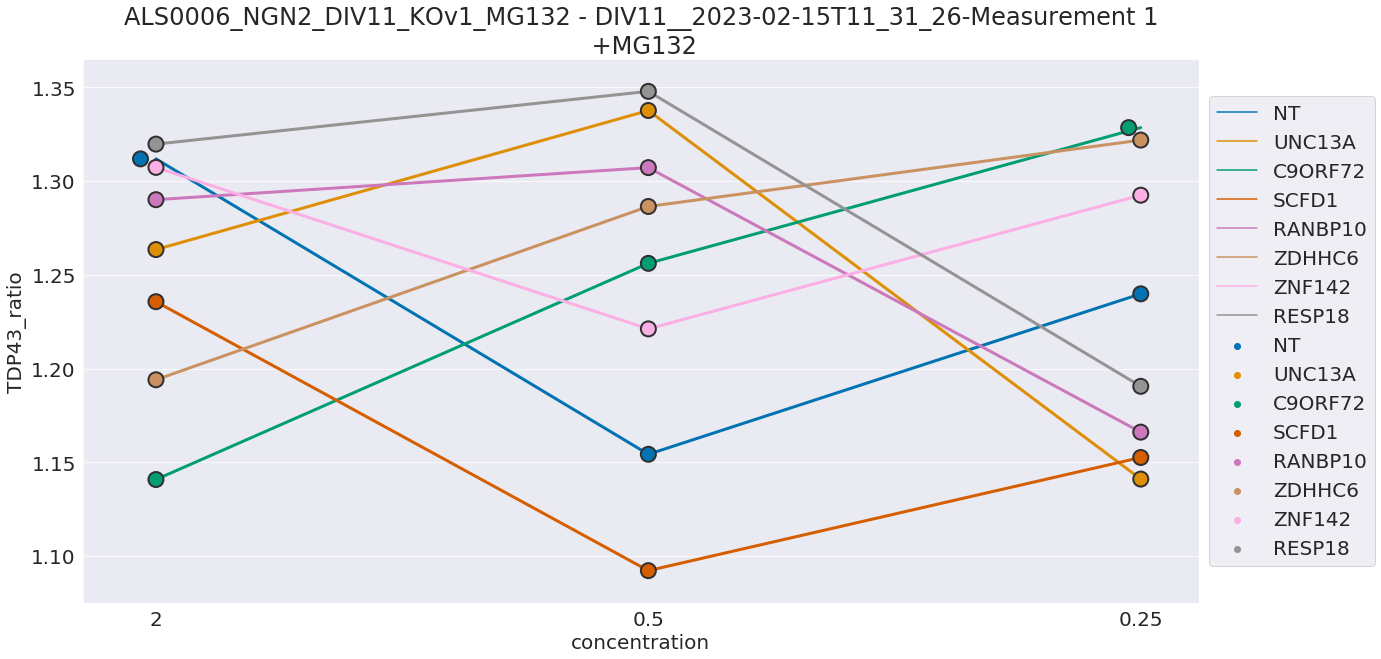

In [59]:
from statannotations.Annotator import Annotator
data = ratio_data.query('treatment=="MG132"')
# data = ratio_data.drop(ratio_data.index[ratio_data['treatment']=='empty'])
x = 'crispr'
y = 'TDP43_ratio'
# ax = sns.boxplot(data=data, x=x, y=y, palette='colorblind')
# plt.ylim([0.8, 1.07])
pairs = [('NT', x) for x in data['crispr'].unique()]
# annot = Annotator(ax, pairs, data=data, x=x, y=y)
# annot.configure(test='t-test_ind', text_format='full',  verbose=2)
# annot.apply_test()
# ax, test_results = annot.annotate()
# sns.lineplot(data=data, x='concentration', y=y, hue=x, linewidth=2, size=10, palette='colorblind')
# sns.swarmplot(data=data, x='concentration', y=y, hue=x, dodge=True, linewidth=2, size=10, palette='colorblind')
sns.swarmplot(data=data, x='concentration', y=y, hue=x,  linewidth=2, size=15, palette='colorblind')
sns.lineplot(data=data, x='concentration', y=y, hue=x, linewidth=3, palette='colorblind')
plt.title('ALS0006_NGN2_DIV11_KOv1_MG132 - DIV11__2023-02-15T11_31_26-Measurement 1\n +MG132')
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))

## DMSO & MG132, all MG132 concentrations

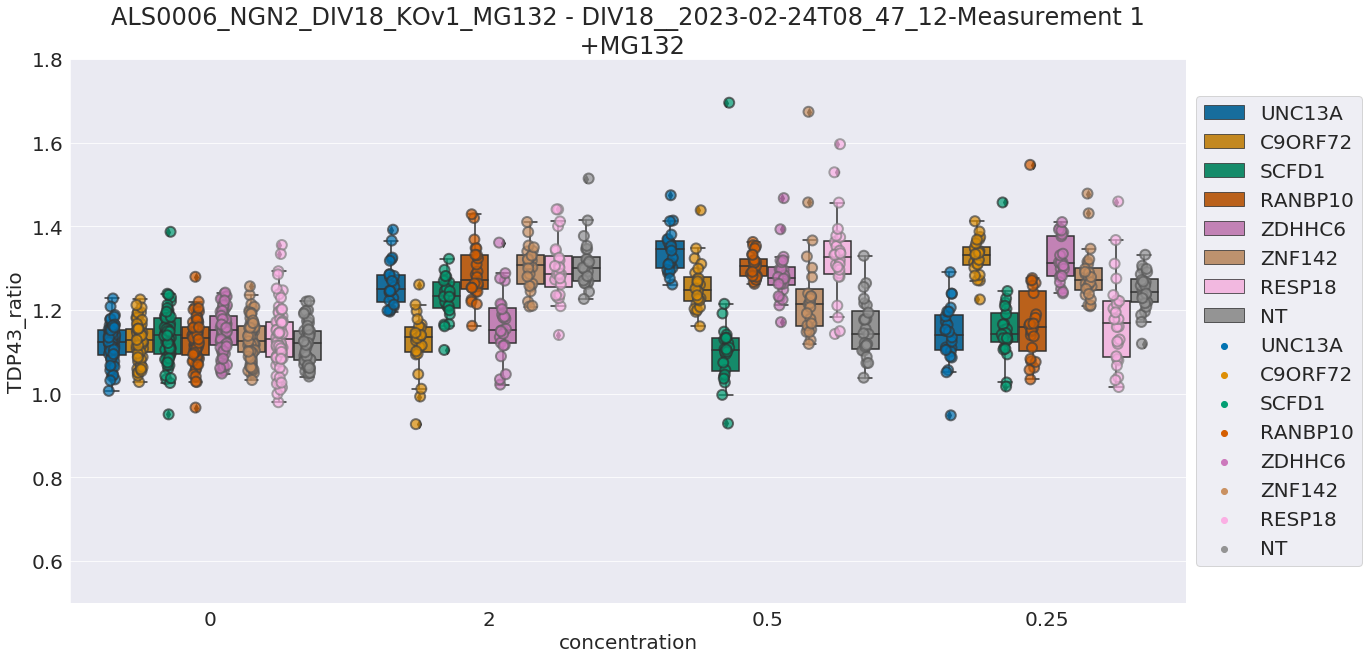

In [100]:
from statannotations.Annotator import Annotator
sns.set_style('darkgrid')
# data = ratio_data.query('treatment=="MG132" or (crispr=="NT" & treatment=="DMSO")')
data = ratio_data.query('treatment=="MG132" or treatment=="DMSO"')
# data = ratio_data.drop(ratio_data.index[ratio_data['treatment']=='empty'])
x = 'crispr'
y = 'TDP43_ratio'
ax = sns.boxplot(data=data, x='concentration', y=y, hue=x, palette='colorblind')
# ax = sns.violinplot(data=data, x=x, y=y, palette='colorblind')
pairs = [('NT', x) for x in data['crispr'].unique()]

plt.title(data_dir.parents[0].name + ' - ' + data_dir.name + '\n +MG132')
plt.ylim([0.5, 1.8])
# plt.ylim([0, 2.5])
# annot = Annotator(ax, pairs, data=data, x=x, y=y)
# annot.configure(test='t-test_ind', text_format='star',  verbose=2)
# annot.apply_test()
# ax, test_results = annot.annotate()
sns.stripplot(data=data, x='concentration', y=y, hue=x,  dodge=True, linewidth=2, size=10, palette='colorblind', alpha=0.7)
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
# plt.gca().invert_xaxis()

## DMSO & MG132, single concentration, broken up by mutant & experiment

/tmp/ipykernel_26402/1175819994.py:18: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  ratio_data = ratio_data.groupby(['FileName_TDP43', 'crispr', 'treatment', 'concentration']).mean()


p-value annotation legend:
      ns: p <= 1.00e+00
       *: 1.00e-02 < p <= 5.00e-02
      **: 1.00e-03 < p <= 1.00e-02
     ***: 1.00e-04 < p <= 1.00e-03
    ****: p <= 1.00e-04

2_UNC13A vs. 2_NT: t-test independent samples with Bonferroni correction, P_val:2.978e-01 t=-2.385e+00
0_UNC13A vs. 0_NT: t-test independent samples with Bonferroni correction, P_val:1.000e+00 t=1.462e+00
p-value annotation legend:
      ns: p <= 1.00e+00
       *: 1.00e-02 < p <= 5.00e-02
      **: 1.00e-03 < p <= 1.00e-02
     ***: 1.00e-04 < p <= 1.00e-03
    ****: p <= 1.00e-04

2_C9ORF72 vs. 2_NT: t-test independent samples with Bonferroni correction, P_val:1.298e-09 t=-8.343e+00
0_C9ORF72 vs. 0_NT: t-test independent samples with Bonferroni correction, P_val:8.826e-01 t=1.877e+00
p-value annotation legend:
      ns: p <= 1.00e+00
       *: 1.00e-02 < p <= 5.00e-02
      **: 1.00e-03 < p <= 1.00e-02
     ***: 1.00e-04 < p <= 1.00e-03
    ****: p <= 1.00e-04

2_SCFD1 vs. 2_NT: t-test independent samples 

/tmp/ipykernel_26402/1175819994.py:18: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  ratio_data = ratio_data.groupby(['FileName_TDP43', 'crispr', 'treatment', 'concentration']).mean()


p-value annotation legend:
      ns: p <= 1.00e+00
       *: 1.00e-02 < p <= 5.00e-02
      **: 1.00e-03 < p <= 1.00e-02
     ***: 1.00e-04 < p <= 1.00e-03
    ****: p <= 1.00e-04

2_UNC13A vs. 2_NT: t-test independent samples with Bonferroni correction, P_val:6.230e-02 t=-2.992e+00
0_UNC13A vs. 0_NT: t-test independent samples with Bonferroni correction, P_val:1.000e+00 t=5.518e-02
p-value annotation legend:
      ns: p <= 1.00e+00
       *: 1.00e-02 < p <= 5.00e-02
      **: 1.00e-03 < p <= 1.00e-02
     ***: 1.00e-04 < p <= 1.00e-03
    ****: p <= 1.00e-04

2_C9ORF72 vs. 2_NT: t-test independent samples with Bonferroni correction, P_val:8.061e-12 t=-9.891e+00
0_C9ORF72 vs. 0_NT: t-test independent samples with Bonferroni correction, P_val:1.000e+00 t=9.185e-01
p-value annotation legend:
      ns: p <= 1.00e+00
       *: 1.00e-02 < p <= 5.00e-02
      **: 1.00e-03 < p <= 1.00e-02
     ***: 1.00e-04 < p <= 1.00e-03
    ****: p <= 1.00e-04

2_SCFD1 vs. 2_NT: t-test independent samples 

Text(884.3055555555555, 0.5, 'DIV18')

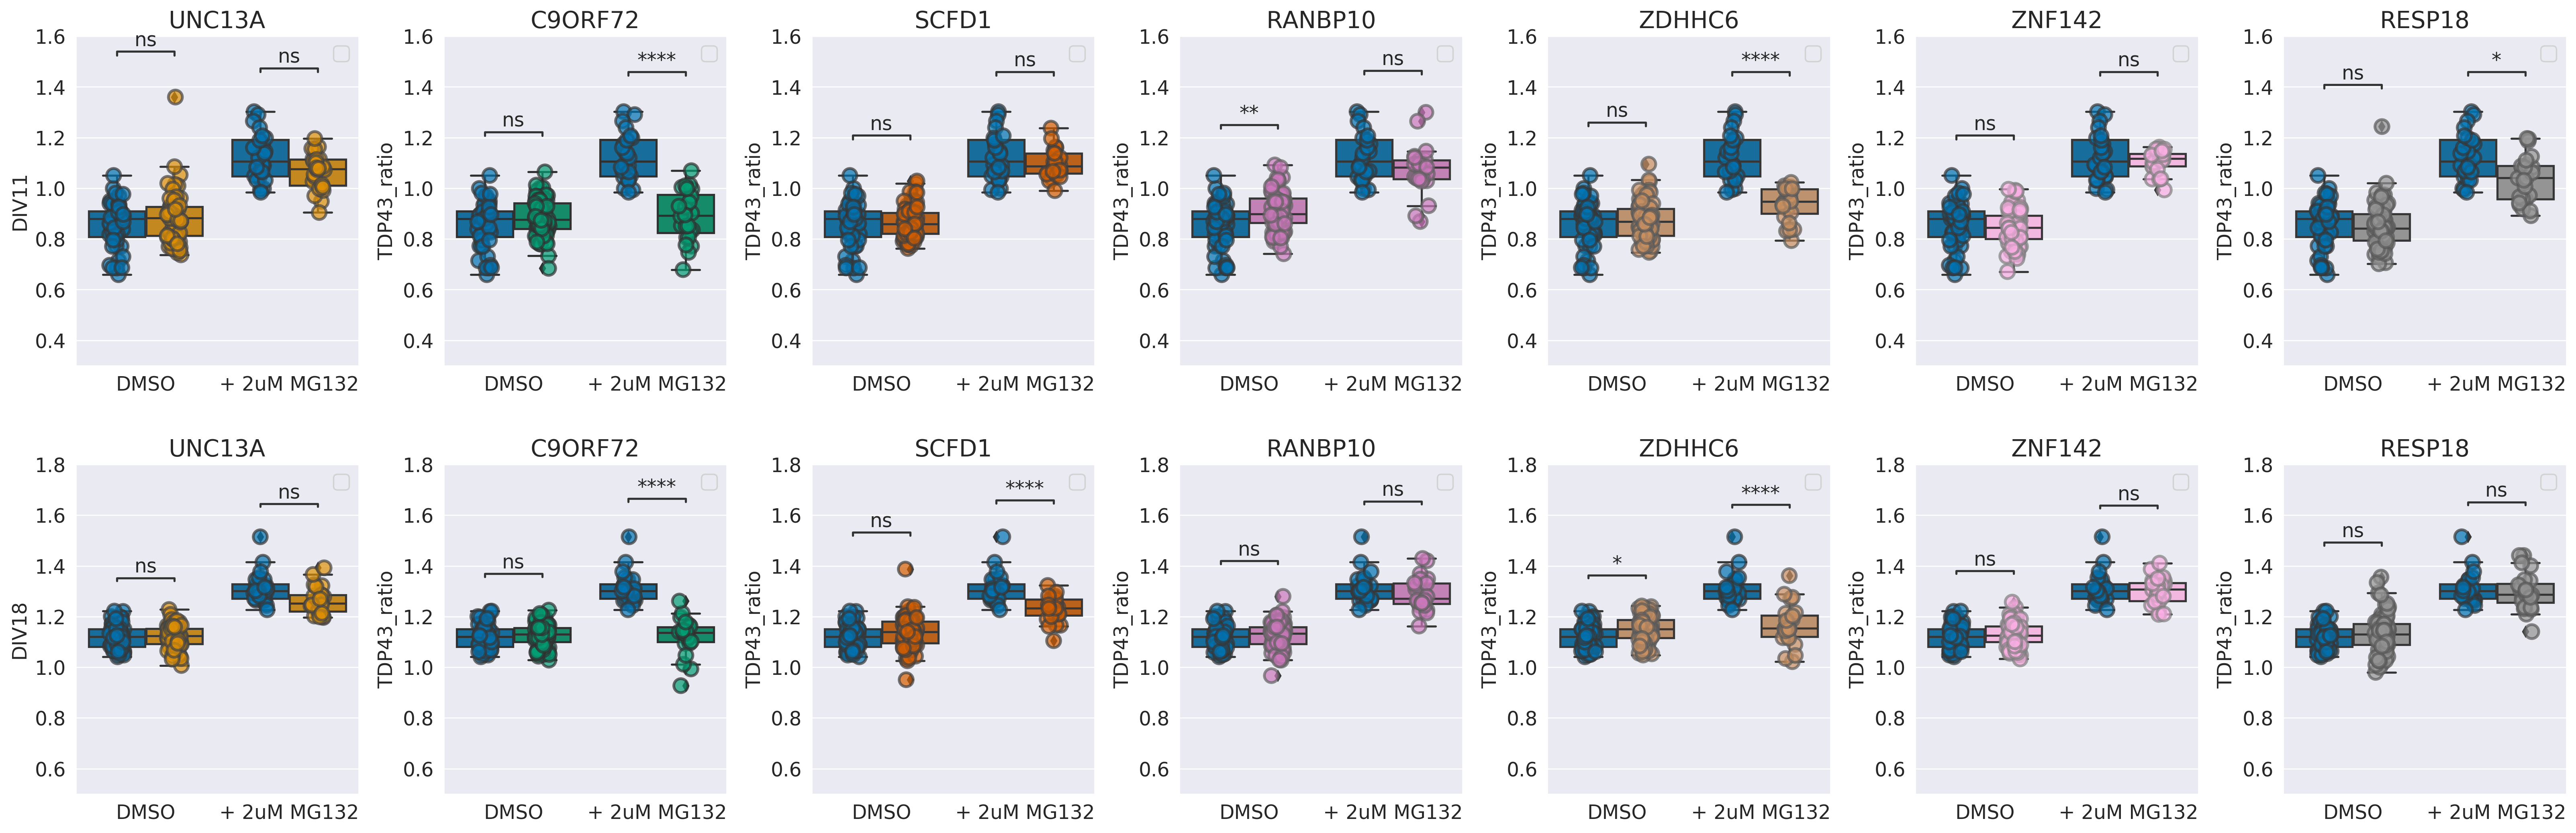

In [170]:
dirs = [Path('/lab/processed-data/ALS0006_NGN2_DIV11_KOv1_MG132/DIV11__2023-02-15T11_31_26-Measurement 1'),
    Path('/lab/processed-data/ALS0006_NGN2_DIV18_KOv1_MG132/DIV18__2023-02-24T08_47_12-Measurement 1')]

sns.set_style('darkgrid')
plt.rcParams['figure.figsize'] = (32, 10)
plt.rcParams['font.size'] = 14
NT_color = sns.color_palette('colorblind')[0]
ylims = [[0.3, 1.6], [0.5, 1.8]]
# crispr_mutants = ratio_data.query('crispr not in["empty", "NT"]')['crispr'].unique()
crispr_mutants = ['UNC13A', 'C9ORF72', 'SCFD1', 'RANBP10', 'ZDHHC6', 'ZNF142',
       'RESP18']
fig, axs = plt.subplots(2, len(crispr_mutants))

for i_exp, data_dir in enumerate(dirs):
    plate = Plate(data_dir, analysis_name)
    ratio_data = calculate_ratio(plate, measurement)
    ratio_data = ratio_data.merge(plate.platemap, on='well_position')
    ratio_data = ratio_data.groupby(['FileName_TDP43', 'crispr', 'treatment', 'concentration']).mean()
    # ratio_data = ratio_data.groupby(['well_position', 'crispr', 'treatment', 'concentration']).mean()
    ratio_data = ratio_data.reset_index()
    ratio_data = ratio_data.drop(ratio_data.index[ratio_data['TDP43_ratio'] > 2])

    # pairs = [[(('0', 'NT'), ('0', crispr)), (('2', 'NT'), ('2', crispr))][0] for crispr in crispr_mutants]
    for i_crispr, crispr in enumerate(crispr_mutants):

        data = ratio_data.query('crispr in ["NT", @crispr] and concentration in ["0", "2"]')
        hue = 'crispr'
        x = 'concentration'
        y = 'TDP43_ratio'
        ax = axs[i_exp,i_crispr]
        crispr_color = sns.color_palette('colorblind')[i_crispr+1]
        hue_order = ['NT', crispr]
        sns.boxplot(ax=ax,data=data, x=x, y=y, hue=hue, hue_order=hue_order, palette=[NT_color, crispr_color])
        sns.stripplot(ax=ax,data=data, x=x, y=y, hue=hue,  hue_order=hue_order, dodge=True, linewidth=2, size=10, palette=[NT_color, crispr_color], alpha=0.7)
        ax.set_xticklabels(['DMSO', '+ 2uM MG132'])
        ax.set_xlabel('')
        ax.legend([])
        ax.set_title(crispr)

        pairs = [(('0', 'NT'), ('0', crispr)), (('2', 'NT'), ('2', crispr))]
        annot = Annotator(ax, pairs, data=data, x=x, y=y, hue=hue)
        annot.configure(test='t-test_ind', text_format='star',  comparisons_correction='bonferroni')
        annot.apply_test(num_comparisons=len(crispr_mutants)*2)
        ax, test_results = annot.annotate(line_offset_to_group=0.2)
        ax.set_ylim(ylims[i_exp])

plt.subplots_adjust(wspace=0.3, hspace=0.3)
axs[0,0].set_ylabel('DIV11')
axs[1,0].set_ylabel('DIV18')

## DMSO & MG132, single concentration, broken up by mutant, experiments grouped

/tmp/ipykernel_26402/904808850.py:19: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  ratio_data = ratio_data.groupby(['FileName_TDP43', 'crispr', 'treatment', 'concentration']).mean()
/tmp/ipykernel_26402/904808850.py:19: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  ratio_data = ratio_data.groupby(['FileName_TDP43', 'crispr', 'treatment', 'concentration']).mean()


p-value annotation legend:
      ns: p <= 1.00e+00
       *: 1.00e-02 < p <= 5.00e-02
      **: 1.00e-03 < p <= 1.00e-02
     ***: 1.00e-04 < p <= 1.00e-03
    ****: p <= 1.00e-04

2_UNC13A vs. 2_NT: t-test independent samples with Bonferroni correction, P_val:4.434e-01 t=-2.181e+00
0_UNC13A vs. 0_NT: t-test independent samples with Bonferroni correction, P_val:1.000e+00 t=8.256e-01
p-value annotation legend:
      ns: p <= 1.00e+00
       *: 1.00e-02 < p <= 5.00e-02
      **: 1.00e-03 < p <= 1.00e-02
     ***: 1.00e-04 < p <= 1.00e-03
    ****: p <= 1.00e-04

2_C9ORF72 vs. 2_NT: t-test independent samples with Bonferroni correction, P_val:1.999e-10 t=-7.689e+00
0_C9ORF72 vs. 0_NT: t-test independent samples with Bonferroni correction, P_val:1.000e+00 t=9.515e-01
p-value annotation legend:
      ns: p <= 1.00e+00
       *: 1.00e-02 < p <= 5.00e-02
      **: 1.00e-03 < p <= 1.00e-02
     ***: 1.00e-04 < p <= 1.00e-03
    ****: p <= 1.00e-04

2_SCFD1 vs. 2_NT: t-test independent samples 

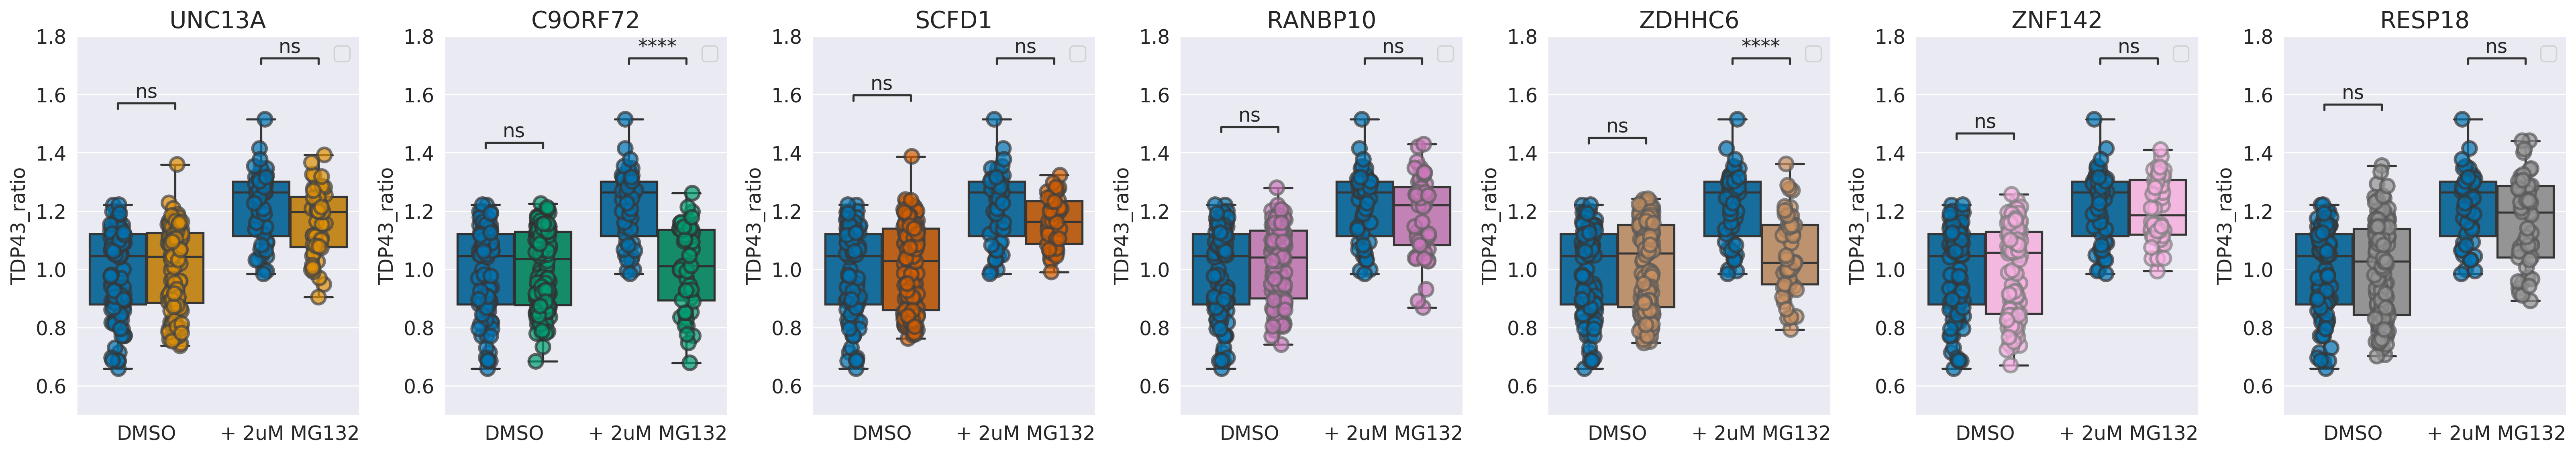

In [183]:
dirs = [Path('/lab/processed-data/ALS0006_NGN2_DIV11_KOv1_MG132/DIV11__2023-02-15T11_31_26-Measurement 1'),
    Path('/lab/processed-data/ALS0006_NGN2_DIV18_KOv1_MG132/DIV18__2023-02-24T08_47_12-Measurement 1')]

sns.set_style('darkgrid')
plt.rcParams['figure.figsize'] = (32, 5)
plt.rcParams['font.size'] = 14
NT_color = sns.color_palette('colorblind')[0]
ylims = [[0.3, 1.6], [0.5, 1.8]]
# crispr_mutants = ratio_data.query('crispr not in["empty", "NT"]')['crispr'].unique()
crispr_mutants = ['UNC13A', 'C9ORF72', 'SCFD1', 'RANBP10', 'ZDHHC6', 'ZNF142',
       'RESP18']
fig, axs = plt.subplots(1, len(crispr_mutants))

r = []
for i_exp, data_dir in enumerate(dirs):
    plate = Plate(data_dir, analysis_name)
    ratio_data = calculate_ratio(plate, measurement)
    ratio_data = ratio_data.merge(plate.platemap, on='well_position')
    ratio_data = ratio_data.groupby(['FileName_TDP43', 'crispr', 'treatment', 'concentration']).mean()
    # ratio_data = ratio_data.groupby(['well_position', 'crispr', 'treatment', 'concentration']).mean()
    ratio_data = ratio_data.reset_index()
    ratio_data = ratio_data.drop(ratio_data.index[ratio_data['TDP43_ratio'] > 2])
    r.append(ratio_data)

ratio_data = pd.concat([r[0], r[1]], axis=0, ignore_index=True)
# pairs = [[(('0', 'NT'), ('0', crispr)), (('2', 'NT'), ('2', crispr))][0] for crispr in crispr_mutants]
for i_crispr, crispr in enumerate(crispr_mutants):

    data = ratio_data.query('crispr in ["NT", @crispr] and concentration in ["0", "2"]')
    hue = 'crispr'
    x = 'concentration'
    y = 'TDP43_ratio'
    ax = axs[i_crispr]
    crispr_color = sns.color_palette('colorblind')[i_crispr+1]
    hue_order = ['NT', crispr]
    sns.boxplot(ax=ax,data=data, x=x, y=y, hue=hue, hue_order=hue_order, palette=[NT_color, crispr_color])
    sns.stripplot(ax=ax,data=data, x=x, y=y, hue=hue,  hue_order=hue_order, dodge=True, linewidth=2, size=10, palette=[NT_color, crispr_color], alpha=0.7)
    ax.set_xticklabels(['DMSO', '+ 2uM MG132'])
    ax.set_xlabel('')
    ax.legend([])
    ax.set_title(crispr)

    pairs = [(('0', 'NT'), ('0', crispr)), (('2', 'NT'), ('2', crispr))]
    annot = Annotator(ax, pairs, data=data, x=x, y=y, hue=hue)
    annot.configure(test='t-test_ind', text_format='star',  comparisons_correction='bonferroni')
    annot.apply_test(num_comparisons=len(crispr_mutants)*2)
    ax, test_results = annot.annotate(line_offset_to_group=0.2)
    ax.set_ylim(ylims[i_exp])

plt.subplots_adjust(wspace=0.3, hspace=0.3)

# Live cell dye experiments

In [17]:
# data_dir = Path('/lab/processed-data/230215_BC_Live/1__2023-02-15T17_25_23-Measurement 2')
# data_dir = Path('/lab/processed-data/230227_iN_B3_DIV28_LiveCell/1__2023-02-27T21_51_31-Measurement 5')
data_dir = Path('/lab/processed-data/230227_iN_B4_DIV14_LiveCell/1__2023-02-27T21_03_45-Measurement 4')
platemap = pd.read_csv(data_dir / 'platemap.csv')
# data = pd.read_csv(data_dir / '2023-02-28_soma_segment' / '2023-02-28_soma_segment_Image.csv')
data = pd.read_csv(data_dir / '2023-02-28_soma_objects' / '2023-02-28_soma_objects_Image.csv')

# Set filename and well position
data['well_position'] = data['FileName_NeuO_pre_illum'].apply(
    lambda fname : chr(int(fname[1:3])+64) + fname[4:6]
)
data = data.merge(platemap, on='well_position')
# data = data.groupby(['well_position', 'crispr']).mean()
data = data.groupby(['FileName_NeuO_pre_illum', 'crispr', 'treatment', 'concentration']).mean()
data = data.reset_index()

/tmp/ipykernel_2650/2149254012.py:14: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  data = data.groupby(['FileName_NeuO_pre_illum', 'crispr', 'treatment', 'concentration']).mean()


/tmp/ipykernel_2650/3053320273.py:4: FutureWarning: Passing `palette` without assigning `hue` is deprecated.
  sns.stripplot(data=data, x='crispr', y=measurement, palette='colorblind', linewidth=2, size=10, alpha=0.7)


Text(0.5, 1.0, '230227_iN_B3_DIV28_LiveCell - 1__2023-02-27T21_51_31-Measurement 5\nIntensity_MeanIntensity_TMRM_masked')

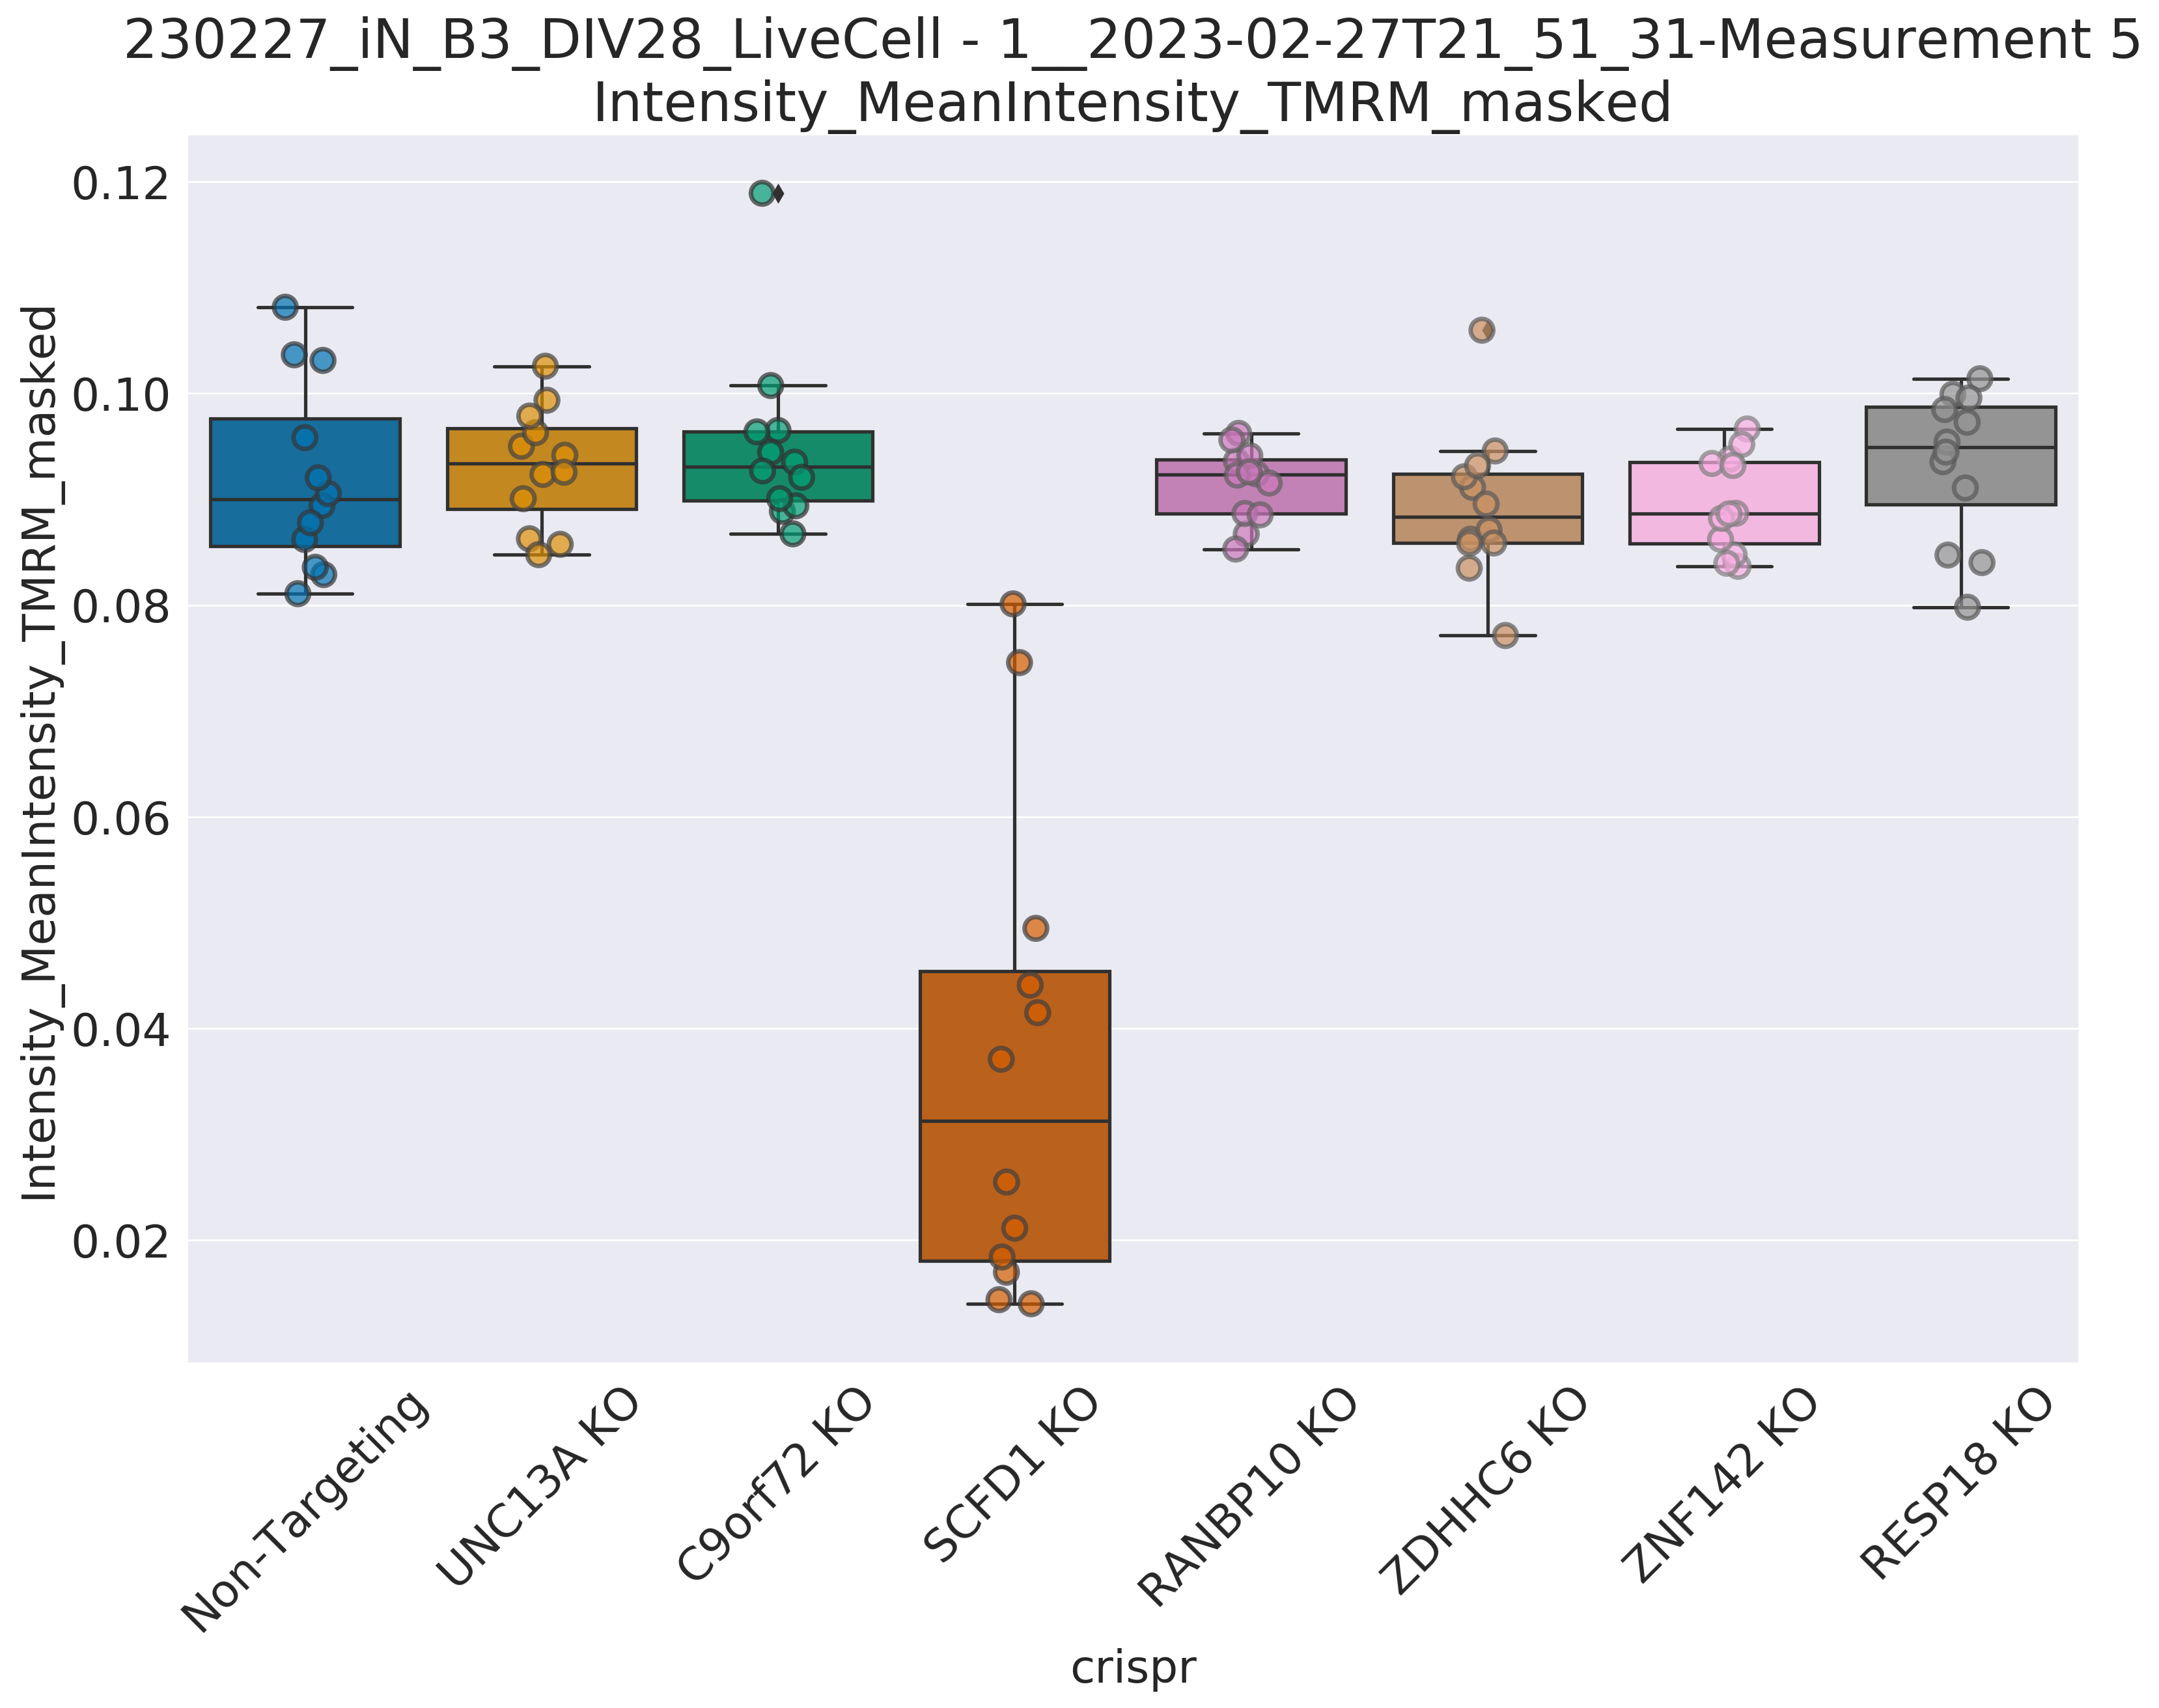

In [16]:
measurement = 'Intensity_MeanIntensity_TMRM_masked'
sns.set_style('darkgrid')
sns.boxplot(data=data, x='crispr', y=measurement, palette='colorblind')
sns.stripplot(data=data, x='crispr', y=measurement, palette='colorblind', linewidth=2, size=10, alpha=0.7)
plt.xticks(rotation=45)
plt.title(data_dir.parents[0].name + ' - ' + data_dir.name + '\n' + measurement)

/tmp/ipykernel_2650/3087782611.py:6: FutureWarning: Passing `palette` without assigning `hue` is deprecated.
  sns.stripplot(data=data, x='crispr', y=measurement, palette='colorblind', linewidth=2, size=10, alpha=0.7)


Text(0.5, 1.0, '230227_iN_B4_DIV14_LiveCell - 1__2023-02-27T21_03_45-Measurement 4\nCount_soma')

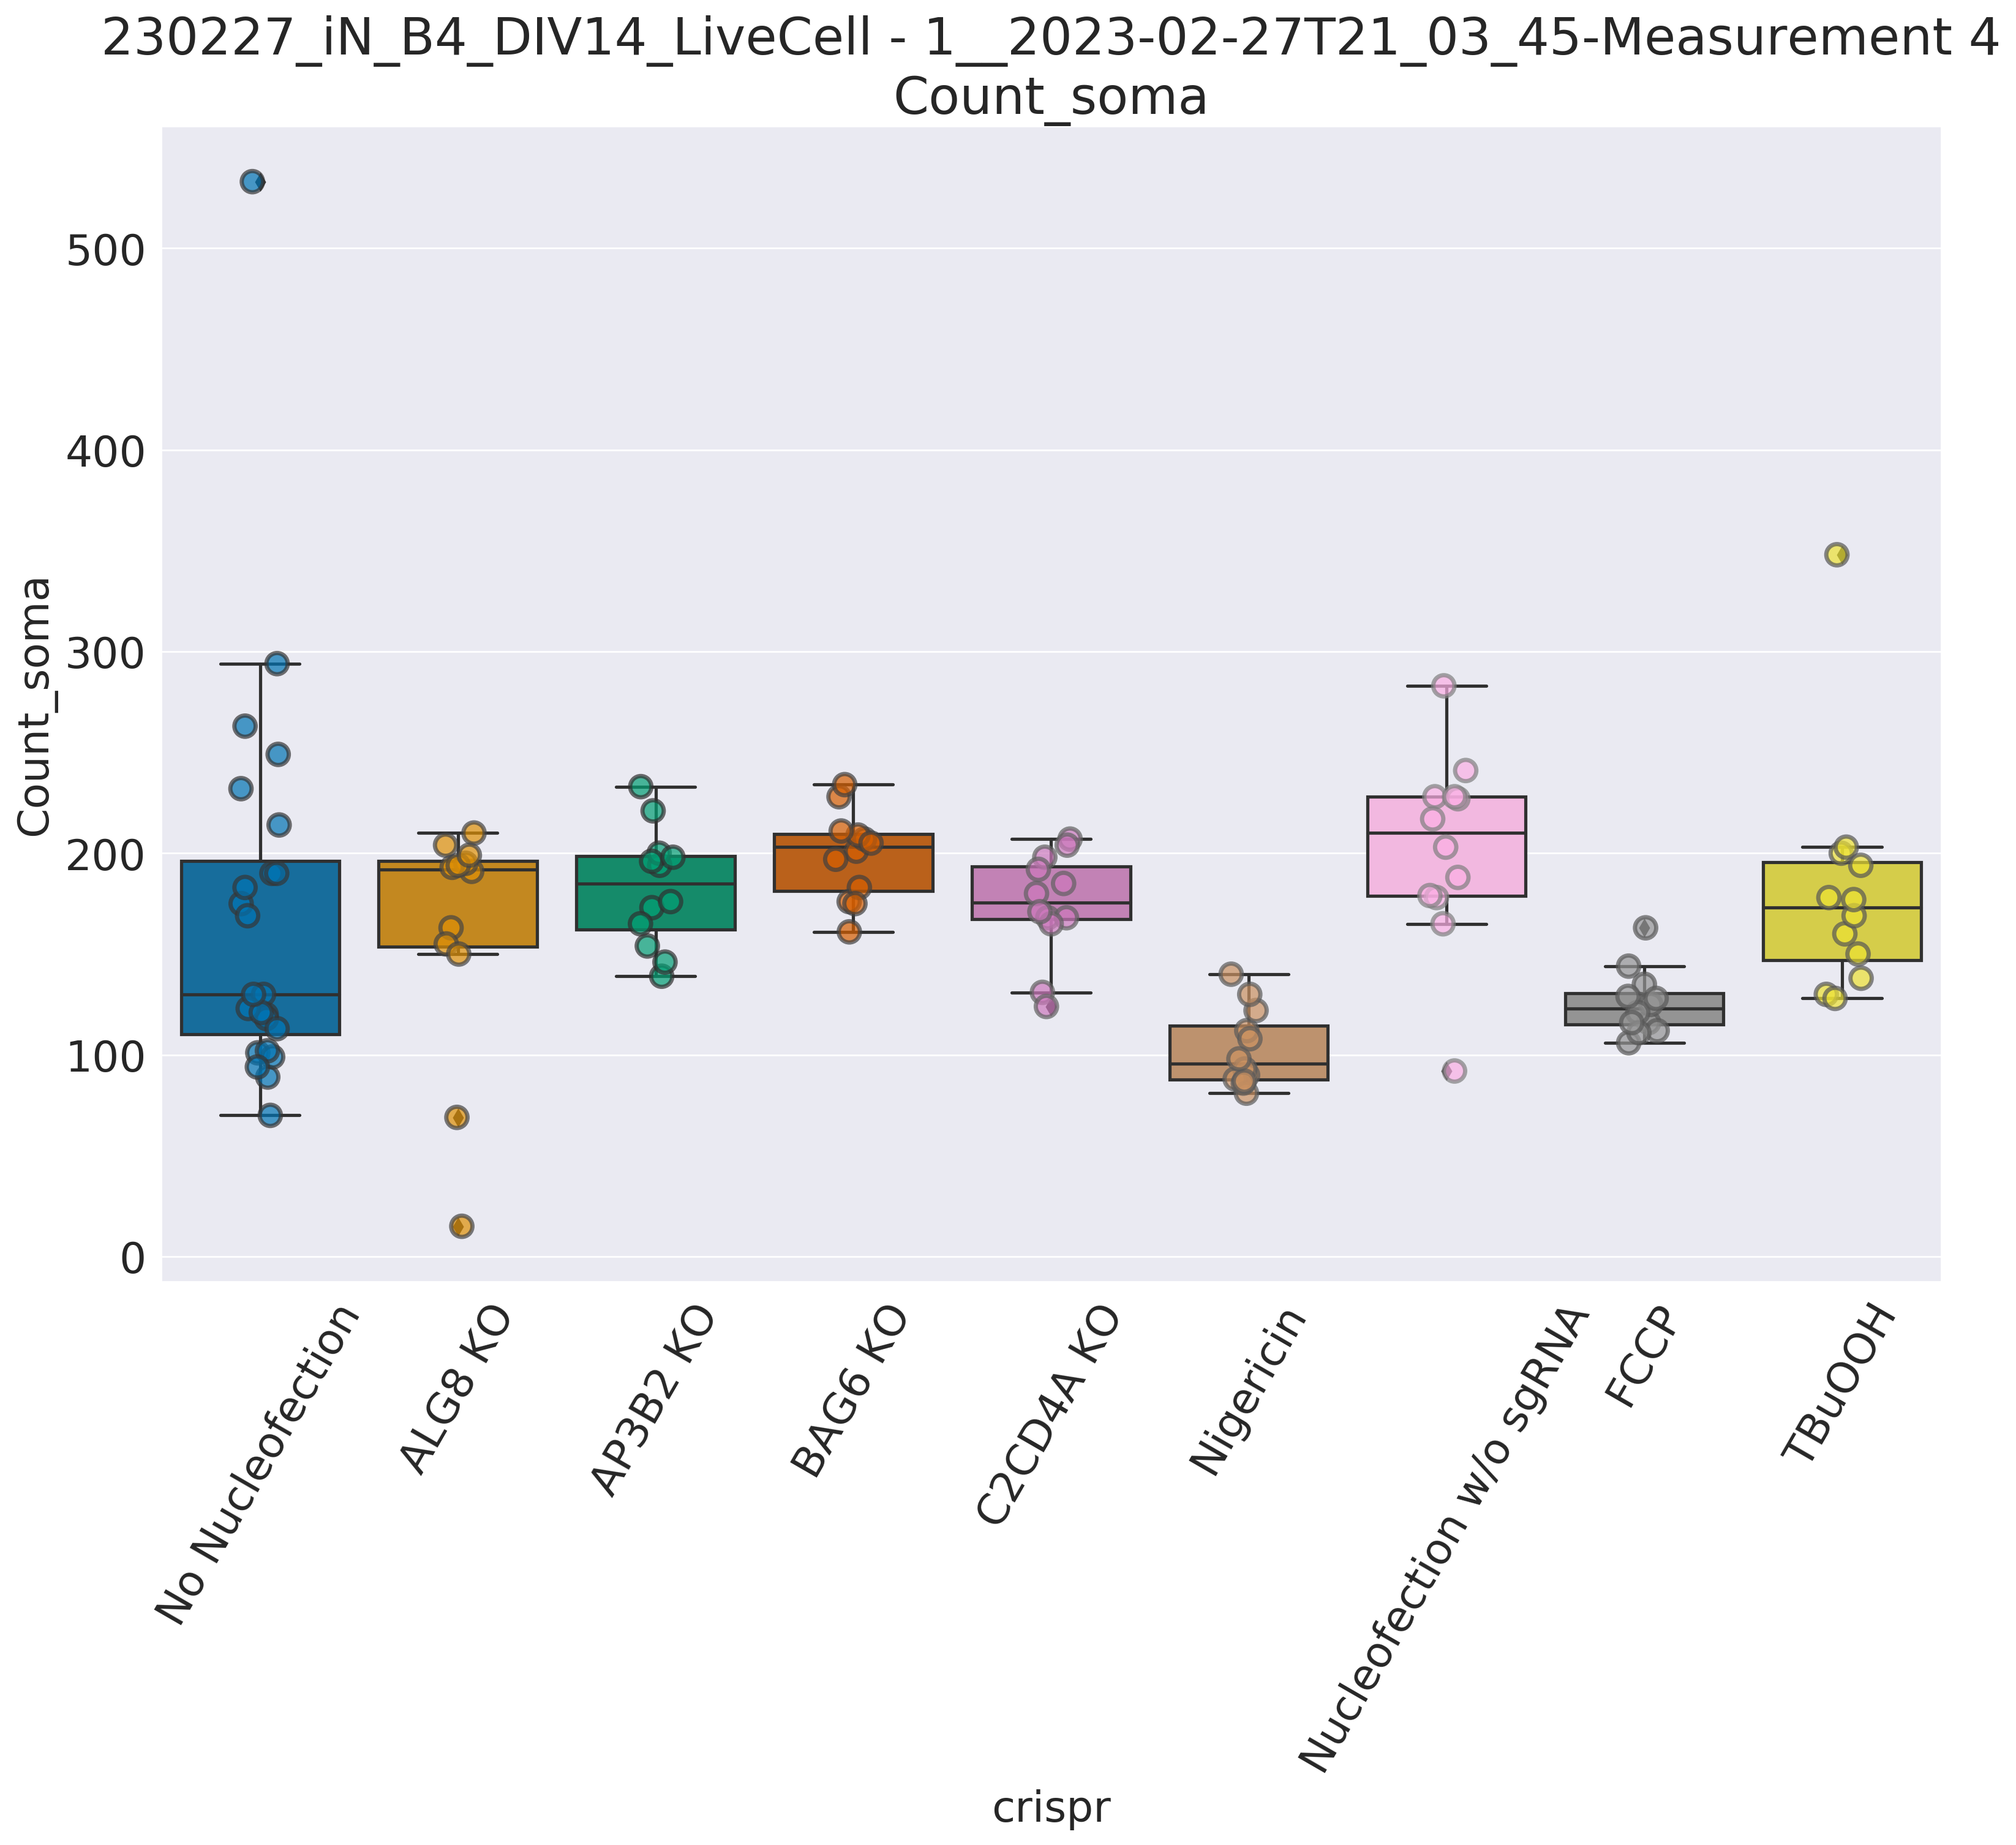

In [21]:
plt.rcParams['figure.figsize'] = (15, 10)
# measurement = 'Median_soma_Intensity_MeanIntensity_CellROX'
measurement = 'Count_soma'
sns.set_style('darkgrid')
sns.boxplot(data=data, x='crispr', y=measurement, palette='colorblind')
sns.stripplot(data=data, x='crispr', y=measurement, palette='colorblind', linewidth=2, size=10, alpha=0.7)
plt.xticks(rotation=60)
plt.title(data_dir.parents[0].name + ' - ' + data_dir.name + '\n' + measurement)

/tmp/ipykernel_2943/3455088285.py:32: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  data = data.groupby(['well_position', 'row', 'col', 'crispr']).mean()


Text(0.5, 1.0, '230227_iN_B3_DIV28_LiveCell - 1__2023-02-27T21_51_31-Measurement 5')

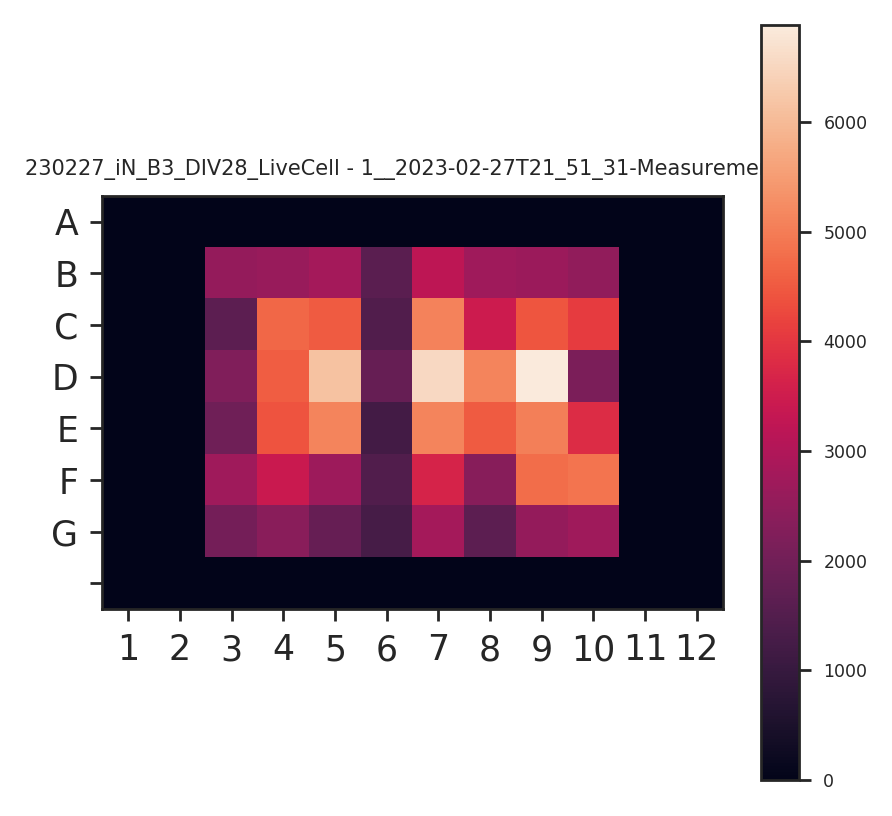

In [21]:
plt.rcParams['figure.figsize'] = (4, 4)
# # measurement = 'Intensity_MeanIntensity_CellROX_masked'
# measurement = 'TDP43_ratio'
# data_dir = Path('/lab/processed-data/ALS0006_NGN2_DIV11_KOv1_MG132/DIV11__2023-02-15T11_31_26-Measurement 1')
# data_dir = Path('/lab/processed-data/ALS0006_NGN2_DIV18_KOv1_MG132/DIV18__2023-02-24T08_47_12-Measurement 1')
# filename = 'FileName_TDP43'
# data = pd.read_csv(data_dir / '2023-02-28_soma_segment' / '2023-02-28_soma_segment_Image.csv')

filename = 'FileName_NeuO_pre_illum'
measurement = 'Intensity_TotalIntensity_NeuO_masked'
# measurement = 'Count_soma'
# data_dir = Path('/lab/processed-data/230215_BC_Live/1__2023-02-15T17_25_23-Measurement 2')
# data_dir = Path('/lab/processed-data/230227_iN_B4_DIV14_LiveCell/1__2023-02-27T21_03_45-Measurement 4')
data_dir = Path('/lab/processed-data/230227_iN_B3_DIV28_LiveCell/1__2023-02-27T21_51_31-Measurement 5')
data = pd.read_csv(data_dir / '2023-02-28_soma_segment' / '2023-02-28_soma_segment_Image.csv')
# data = pd.read_csv(data_dir / '2023-02-28_soma_objects' / '2023-02-28_soma_objects_Image.csv')

platemap = pd.read_csv(data_dir / 'platemap.csv')

# Set filename and well position
plate = np.zeros([8, 12])
data['well_position'] = data[filename].apply(
    lambda fname : chr(int(fname[1:3])+64) + fname[4:6]
)
data['row'] = data[filename].apply(
    lambda fname : int(fname[1:3])
)
data['col'] = data[filename].apply(
    lambda fname : int(fname[4:6])
)
data = data.merge(platemap, on='well_position')
data = data.groupby(['well_position', 'row', 'col', 'crispr']).mean()
# data = data.groupby(['FileName_NeuO_pre_illum', 'crispr', 'treatment', 'concentration']).mean()
data = data.reset_index()
plate[data['row']-1, data['col']-1] = data[measurement]
plt.imshow(plate)
plt.xticks([0,1,2,3,4,5,6,7,8,9,10,11], [1,2,3,4,5,6,7,8,9,10,11,12], fontsize=10)
plt.yticks([0,1,2,3,4,5,6,7], ['A','B','C','D','E','F','G'], fontsize=10)
plt.colorbar()
plt.title(data_dir.parents[0].name + ' - ' + data_dir.name)


In [22]:
plt.rcParams['figure.figsize'] = (4, 4)
plt.rcParams['font.size'] = 5
sns.set_style('ticks')
# data_dir = Path('/lab/processed-data/ALS0006_NGN2_DIV11_KOv1_MG132/DIV11__2023-02-15T11_31_26-Measurement 1')
# data_dir = Path('/lab/processed-data/ALS0006_NGN2_DIV18_KOv1_MG132/DIV18__2023-02-24T08_47_12-Measurement 1')
# data_dir = Path('/lab/processed-data/ALS0002_NGN2_DIV11_MG132DRCv3/DIV11 v3 lower AF488__2023-02-15T08_40_16-Measurement 1')
data_dir = Path('/lab/processed-data/ALS0002_NGN2_DIV18_MG132DRCv3/DIV18v2__2023-02-21T14_27_22-Measurement 1')
analysis_name = '2023-02-17_tdp43seg_tdp-43'
measurement = 'Intensity_IntegratedIntensity_TDP43_corrected'

plate = Plate(data_dir, analysis_name)
ratio_data = calculate_ratio(plate, measurement)
ratio_data = ratio_data.merge(plate.platemap, on='well_position')
# ratio_data = ratio_data.groupby(['well_position', 'crispr', 'treatment', 'concentration']).mean()
ratio_data = ratio_data.groupby(['well_position', 'treatment', 'concentration']).mean()
# ratio_data = ratio_data.groupby(['FileName_TDP43', 'crispr', 'treatment', 'concentration']).mean()
ratio_data = ratio_data.reset_index()

# 
plate_data = np.zeros([8, 12])
plate_data[ratio_data['row'].astype(int)-1, ratio_data['col'].astype(int)-1] = ratio_data['TDP43_ratio']
plt.imshow(plate_data, vmax=1.5, vmin=0.5)
# plt.pcolor(plate_data, vmax=1.5, vmin=0.5)
plt.xticks(np.array([0,1,2,3,4,5,6,7,8,9,10,11]), [1,2,3,4,5,6,7,8,9,10,11,12], fontsize=10)
plt.yticks(np.array([0,1,2,3,4,5,6,7]), ['A','B','C','D','E','F','G'], fontsize=10)
plt.colorbar(shrink=0.5)
plt.title(data_dir.parents[0].name + ' - ' + data_dir.name)

KeyError: 'Intensity_TotalIntensity_TDP43_corrected'

In [229]:
ratio_data

FileName_TDP43  crispr treatment concentration  row  \
0     r02c03f01p01-ch2sk1fk1fl1.tiff   empty     empty         empty  2.0   
1     r02c03f02p01-ch2sk1fk1fl1.tiff   empty     empty         empty  2.0   
2     r02c03f03p01-ch2sk1fk1fl1.tiff   empty     empty         empty  2.0   
3     r02c03f04p01-ch2sk1fk1fl1.tiff   empty     empty         empty  2.0   
4     r02c03f05p01-ch2sk1fk1fl1.tiff   empty     empty         empty  2.0   
...                              ...     ...       ...           ...  ...   
1141  r07c10f20p01-ch2sk1fk1fl1.tiff  RESP18     MG132          0.25  7.0   
1142  r07c10f21p01-ch2sk1fk1fl1.tiff  RESP18     MG132          0.25  7.0   
1143  r07c10f22p01-ch2sk1fk1fl1.tiff  RESP18     MG132          0.25  7.0   
1144  r07c10f23p01-ch2sk1fk1fl1.tiff  RESP18     MG132          0.25  7.0   
1145  r07c10f24p01-ch2sk1fk1fl1.tiff  RESP18     MG132          0.25  7.0   

       col  TDP43_nucleus  TDP43_cytoplasm  TDP43_ratio  
0      3.0       0.010033         0.010710     1.073447  
1      3.0       0.009884         0.011671     1.178585  
2      3.0       0.008779              NaN          NaN  
3      3.0       0.009206         0.009893     1.078729  
4      3.0       0.009180         0.007916     0.862300  
...    ...            ...              ...          ...  
1141  10.0       0.105083         0.074807     0.757744  
1142  10.0       0.095453         0.077363     0.852819  
1143  10.0       0.108098         0.091459     0.972107  
1144  10.0       0.106428         0.083658     0.868957  
1145  10.0       0.092817         0.084644     1.012864  

[1146 rows x 9 columns]